# Custom Model
The idea is to create a model that represents the relation between price and demand.

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from autograd import grad
import autograd.numpy as anp
from statsmodels.tsa.seasonal import seasonal_decompose

rand = np.random.RandomState(13)

Our study is motivated by the econometric relation between demand and price known as double-logarithmic demand model:

\begin{equation}
D = \alpha P^\beta
\label{eqn:initeq}
\end{equation}
or
\begin{equation}
\log{D} = C + \beta \log{P} 
\label{eqn:Einstein}
\end{equation}

The loss function to minimise will be an L2 norm fitting of the demand:

\begin{equation}
f_1(w) = \sqrt{\sum_{j=1}^{n} |D_j - \hat{D}_j(w,x_i)|^2 }
\label{eqn:loss}
\end{equation}

The learning algorithm used will be gradient descent with adaptive stepsize which is one of the most popular unconstrained optimization methods for N-dimensional problems. It has an iterative structure and as the rest of the general gradient methods follows:

\begin{equation}
w_{k+1} = w_{k} - \alpha_k \nabla f(w_{k})
\end{equation}

We will use autograd for obtaining the gardient of the function. Our first loss will penalise the misfitting between the predicted and real demands.
Reparametrization trick

In [ ]:
#We define the loss
def my_autograd_loss(d,X,w,model):
    n_var = X.shape[1]    
    d_hat = model(X,w)
    fit = (d-d_hat)
    fit_norm = anp.linalg.norm(fit)
    
    return fit_norm

#Autograd gradient
my_training_gradient = grad(my_autograd_loss,2)

#Model for creating the synthetic data
def model1_data(X,w,noise_p):
    noise = anp.random.normal(0,noise_p,X.shape[0])
    y = anp.exp(w[0]-w[1]*(anp.log(X[:,0]))+w[2]*noise)
    return y

#Model to learn
def model1(X,w):
    y = anp.exp(w[0]-w[1]*(anp.log(X[:,0])))#+w[2]*anp.random.normal(0,1,X.shape[0]))
    return y

def model1_res(X,w):
    y = -w[2] + anp.exp(w[0]-w[1]*(anp.log(X[:,0])))#+w[2]*anp.random.normal(0,1,X.shape[0]))
    return y

#Model for creating the synthetic data
def model1_datab(X,w,noise_p):
    noise = anp.random.normal(0,noise_p,X.shape[0])
    y = anp.exp(-w[0]*(anp.log(w[1]*X[:,0]))+w[2]*noise)
    return y

#Model to learn
def model1b(X,w):
    y = anp.exp(w[0]*(anp.log(w[1]*X[:,0])))#+w[2]*anp.random.normal(0,1,X.shape[0]))
    return y

#Model for creating the synthetic data
def model2_data(X,w,noise_p):
    noise = anp.random.normal(0,noise_p,X.shape[0])
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[3]*X[:,3]
    y = anp.exp(w[0]- beta*anp.log(X[:,0]) - beta*(w[4])+w[5]*noise)
    return y

#Model to learn
def model2(X,w):
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[3]*X[:,3]
    y = anp.exp(w[0]- beta*anp.log(X[:,0])- beta*(w[4]))
    return y

#Model to learn for the residual
def model2_res(X,w):
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[3]*X[:,3]
    y = -w[5] + anp.exp(w[0]- beta*anp.log(X[:,0])- beta*(w[4]))
    return y


### Synthetic data verification
We now create synthetic data with some noise on it.

In [ ]:
#first define price
p = rand.uniform(20,50,50)

#create the dataframe
dades = {'p':p}
sim2 = pd.DataFrame(data=dades)

#parameters of the data
gen_params = [4.5,0.1,0.1]

#define demand following model with noise parameter
sim2['d'] = model1_data(sim2.values,gen_params,0.1)

sim2.head(5)

Let's check if the model can learn the weights of the synthetic data:

In [ ]:
X = sim2.values[:,:-1]
d = sim2.values[:,-1]
w =np.ones(3)
w_o =np.ones(3)
loss = 10e10
loss_o = 10e11
Niterations = 10000000
eta=0.001
nit=0
used_model = model1

start_time = time.time()

#we start the iterations for the gradient descent 
while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
    if loss>loss_o:
        eta = eta*0.7
        print('eta',eta) 
    w_o = w
    loss_o = loss
    
    gradients = my_training_gradient(d, X, w, model=used_model)
    w -= eta*gradients
    
    loss = my_autograd_loss(d,X,w,model=used_model)
    #print(nit, loss)
    
    if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
    nit+=1

print("nit",nit)

print("Generative params")
print(gen_params)
print("Estimated params")
print(w)
print('loss: ',my_autograd_loss(d,X,w,model=used_model))

print("Real values:")
print(d)
print("Predicted values:")
d_p = used_model(X,w)
print(d_p)
plt.scatter(X[:,0],d)
plt.scatter(X[:,0],d_p)

### Real Data
We first prepare our data for the model. In order to represent the periodicity of the weeks we use sinus and cos. 

In [130]:
data = pd.read_csv('../Data/TFM_Hdataset_clean.csv', index_col=0)


conditions = [(data['Year']!= 2019) & (data['Year']!= 2021),
              (data['Year']== 2019),
              (data['Year']!= 2019)]

vals = [np.sin(2*np.pi*data['Week']/52),
        np.sin(2*np.pi*data['Week']/53),
        np.sin(2*np.pi*data['Week']/50)
       ]

vals2 = [np.cos(2*np.pi*data['Week']/52),
        np.cos(2*np.pi*data['Week']/53),
        np.cos(2*np.pi*data['Week']/50)
       ]
data['Week_sin'] = np.select(conditions,vals)
data['Week_cos'] = np.select(conditions,vals2)


channel_pound = [ 'Retail - Concessions', 'Retail - Full Price','Retail - Concessions','UK Offline', 'UK Online',
 'Retail - Outlet', 'UK Direct',  'Wholesale', 
 'Digital Partnerships',  'Retail' ]
channel_euro = ['DE Direct','Euro Direct','EU Direct']
channel_dollar = ['US Direct','US Online', 'US Offline']

data['Country'] =  np.select( [
                                    (data['Channel'].isin(channel_pound)),
                                    (data['Channel'].isin(channel_euro)),
                                    (data['Channel'].isin(channel_dollar))
                                ],[
                                    'UK',
                                    'US',
                                    'EU'
                                ])

data = data[(data['Year']!=2021)&(data['Year']!=2020)&(data['Year']!=2019)]
data

Description Seasonality  Year  Week    Channel        WSSI Category  \
1           Astrid         OLD  2017     1  DE Direct  Womens Active Shoes   
3        Charmaine          SS  2017     1  DE Direct  Womens Formal Shoes   
4            Chile          SS  2017     1  DE Direct  Womens Casual Shoes   
5         Devotion          AW  2017     1  DE Direct      Womens Slippers   
6            Donna        CONT  2017     1  DE Direct  Womens Formal Shoes   
...            ...         ...   ...   ...        ...                  ...   
181660        Wrap         OLD  2018    52  Wholesale      Womens Slippers   
181661        Wrap          SS  2018    52  Wholesale      Womens Slippers   
181662        Wrap          AW  2018    52  Wholesale      Womens Slippers   
181663        York          AW  2018    52  Wholesale  Womens Formal Boots   
181664        Zara          AW  2018    52  Wholesale  Womens Formal Shoes   

        LIMITED EDITION STYLES  Originals        Source  sales  ...  \
1                          0.0        0.0          NONE    1.0  ...   
3                          0.0        0.0          NONE    1.0  ...   
4                          0.0        0.0          NONE    1.0  ...   
5                          0.0        0.0          NONE    2.0  ...   
6                          0.0        0.0          NONE    1.0  ...   
...                        ...        ...           ...    ...  ...   
181660                     0.0        0.0  MANUFACTURED    1.0  ...   
181661                     0.0        0.0  MANUFACTURED   22.0  ...   
181662                     0.0        0.0  MANUFACTURED   37.0  ...   
181663                     0.0        0.0  MANUFACTURED   89.0  ...   
181664                     0.0        0.0       SOURCED   17.0  ...   

              Date      Price  Discount     Margin        RRP   Markdown  \
1       2017-01-08  38.526679  0.000000  25.758448  50.378410  11.851731   
3       2017-01-08  58.225767  0.000000  44.100962  58.395499   0.169733   
4       2017-01-08  58.225767  0.000000  46.649675  58.395499   0.169733   
5       2017-01-08  26.457288  0.000000  17.882101  34.688819   8.231530   
6       2017-01-08  69.982735  0.000000  54.114939  70.192570   0.209836   
...            ...        ...       ...        ...        ...        ...   
181660  2018-12-31  23.950000  1.260000   9.710000  45.833333  20.623333   
181661  2018-12-31  25.152727  0.057273  11.712727  49.166666  23.956666   
181662  2018-12-31  17.769459  0.000000   4.329459  49.166666  31.397207   
181663  2018-12-31  31.961461  0.000000  11.904719  79.166666  47.205206   
181664  2018-12-31  29.971765  0.000000   7.911765  70.833333  40.861568   

             Cost      Week_sin  Week_cos  Country  
1       12.768232  1.205367e-01  0.992709       US  
3       14.124805  1.205367e-01  0.992709       US  
4       11.576091  1.205367e-01  0.992709       US  
5        8.575187  1.205367e-01  0.992709       US  
6       15.867796  1.205367e-01  0.992709       US  
...           ...           ...       ...      ...  
181660  14.240000  6.432491e-16  1.000000       UK  
181661  13.440000  6.432491e-16  1.000000       UK  
181662  13.440000  6.432491e-16  1.000000       UK  
181663  20.056742  6.432491e-16  1.000000       UK  
181664  22.060000  6.432491e-16  1.000000       UK  

[155156 rows x 27 columns]

We will focus on the products with more data for UK

In [96]:
data[data['Country']=='UK'][['Description','WSSI Category']].value_counts().head(60)

Description             WSSI Category            
Shake                   Womens Casual Shoes          2678
Tone                    Womens Casual Shoes          2377
Leanne                  Womens Active Shoes          2125
Dew                     Womens Casual Shoes          2106
Leap                    Womens Casual Shoes          2033
Jewel                   Womens Casual Shoes          2006
Donna                   Womens Formal Shoes          2004
Mist GTX                Womens Goretex               1843
Sugar                   Womens Casual Shoes          1782
Wrap                    Womens Slippers              1764
Sunset                  Womens Casual Shoes          1745
Angel                   Womens Smart Casual Shoes    1731
Calypso                 Womens Casual Shoes          1602
Lance                   Mens Formal Shoes            1588
Charmaine               Womens Formal Shoes          1582
Nirvana                 Womens Casual Shoes          1568
Energise              

In [131]:

aggregations = {'Price':'mean',
               'prev_sales':'sum', 
                'Week_sin':'mean',
                'Week_cos':'mean',
                'Discount':'mean',
               'sales':'sum'
               }

#products we will evaluate 
products = ['Suede And Nubuck Brush',"Hotter Women's Insoles",'Footwear Cleaner','Renovating Cream', 'Wax Oil','Shake','Rutland GTX','Laurel', 'Leanne','Solar','Nova', 'Tone']

We try now with real data

Product Suede And Nubuck Brush
Channel UK Direct
nit 45609
Estimated params
[ 4.0229004 -0.7049523]
loss:  595.0802411832647


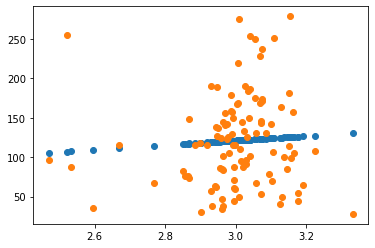

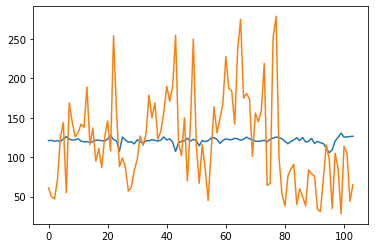

Product Suede And Nubuck Brush
Channel Retail - Full Price
nit 4441
Estimated params
[6.17899991 0.72798762]
loss:  649.7801177102697


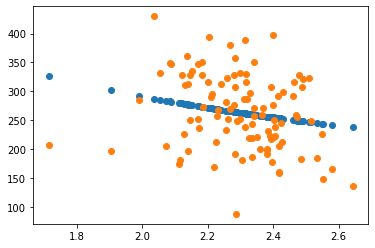

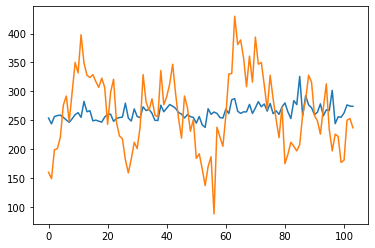

Product Hotter Women's Insoles
Channel UK Direct
nit 77011
Estimated params
[3.49353247 0.03132405]
loss:  158.25639367991275


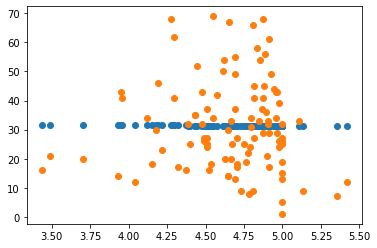

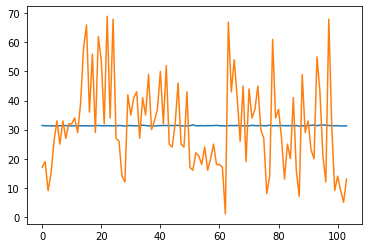

Product Hotter Women's Insoles
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
nit 143493
Estimated params
[11.24422812  3.47255265]
loss:  818.676972391599


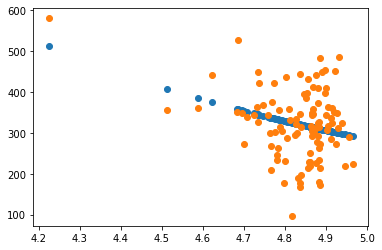

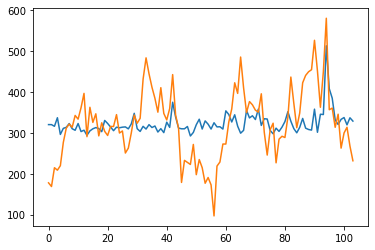

Product Footwear Cleaner
Channel UK Direct
nit 50051
Estimated params
[ 2.98059164 -1.84901254]
loss:  1311.0348703498908


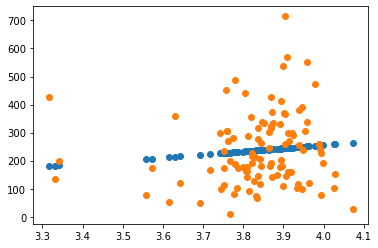

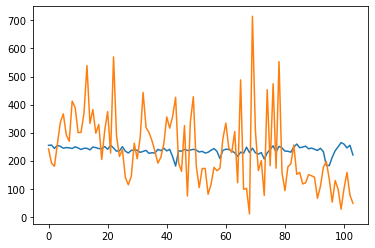

Product Footwear Cleaner
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
nit 109428
Estimated params
[-1.37019817 -5.52909902]
loss:  1286.6016396602208


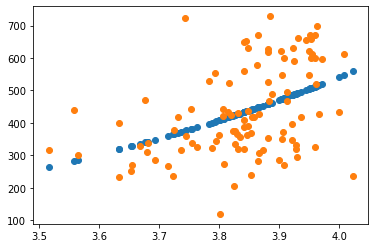

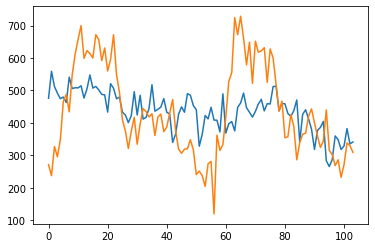

Product Renovating Cream
Channel UK Direct
eta 7e-05
nit 35395
Estimated params
[9.62113169 3.12765962]
loss:  1856.4326801031004


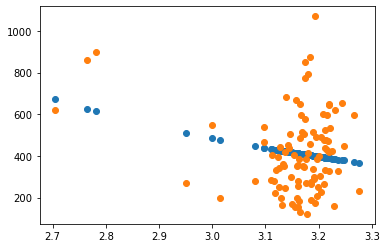

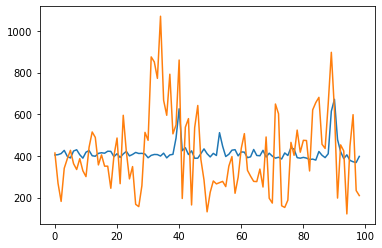

Product Renovating Cream
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
nit 33869
Estimated params
[10.45846122  2.98525099]
loss:  4160.338873530995


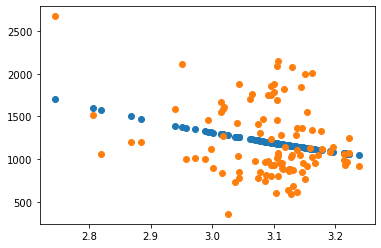

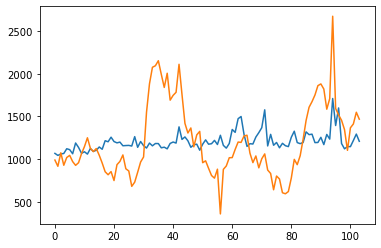

Product Wax Oil
Channel UK Direct
nit 187371
Estimated params
[2.5232925  0.65972613]
loss:  35.063731488208184


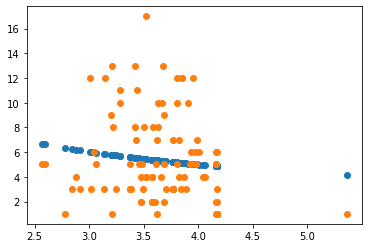

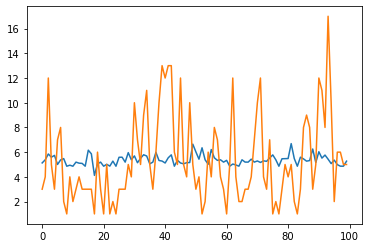

Product Wax Oil
Channel Retail - Full Price
nit 167687
Estimated params
[4.81165985 1.04896361]
loss:  185.46486644118357


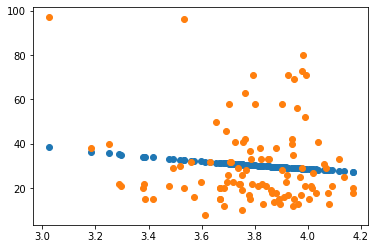

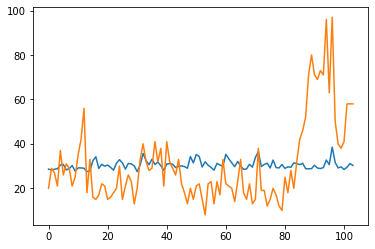

Product Shake
Channel UK Direct
eta 7e-05
nit 14583
Estimated params
[ 4.77079543 -0.02648582]
loss:  3384.9307515547866


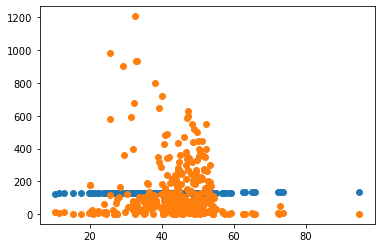

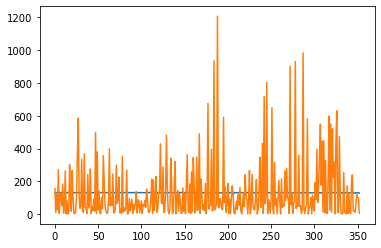

Product Shake
Channel Retail - Full Price
nit 1
Estimated params
[nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


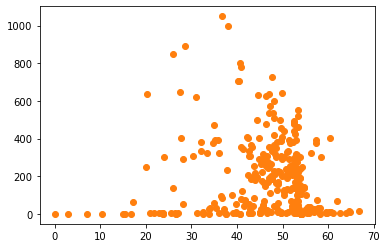

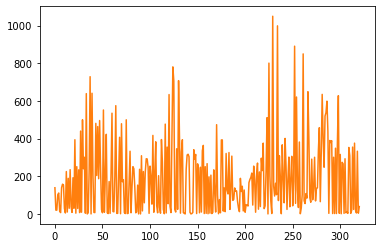

Product Rutland GTX
Channel UK Direct
nit 1
Estimated params
[nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


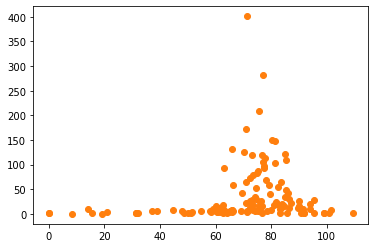

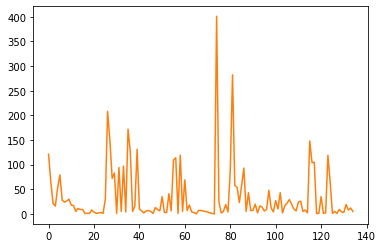

Product Rutland GTX
Channel Retail - Full Price
nit 43121
Estimated params
[ 2.09207469 -0.27512492]
loss:  355.1191239489124


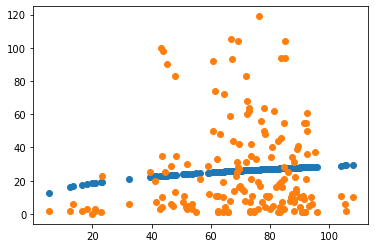

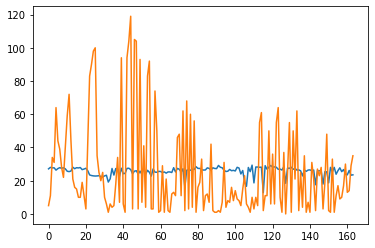

Product Laurel
Channel UK Direct
nit 1
Estimated params
[nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


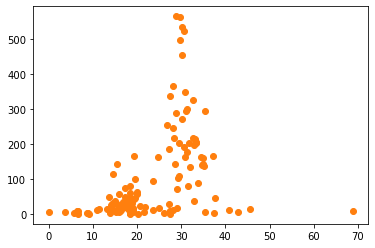

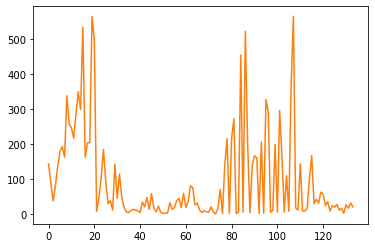

Product Laurel
Channel Retail - Full Price
nit 13999
Estimated params
[ 3.59678853 -0.27588886]
loss:  846.8765969415738


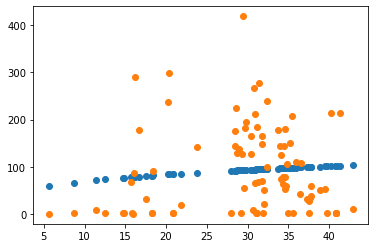

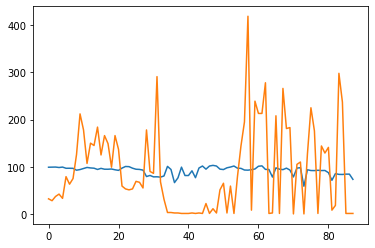

Product Leanne
Channel UK Direct
nit 1
Estimated params
[nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


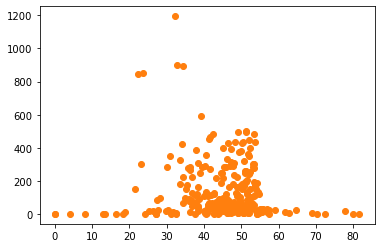

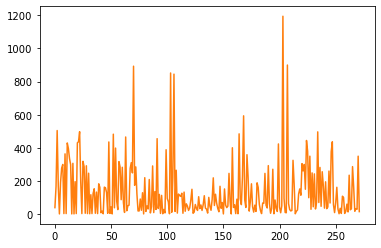

Product Leanne
Channel Retail - Full Price
nit 1
Estimated params
[nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


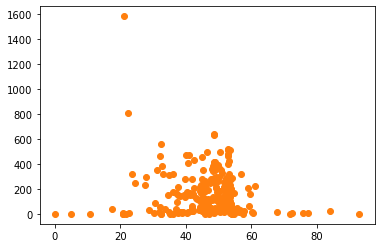

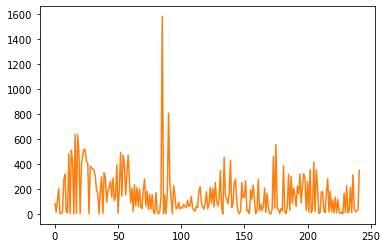

Product Solar
Channel UK Direct
nit 33220
Estimated params
[9.19232059 1.41383886]
loss:  1665.0237824241


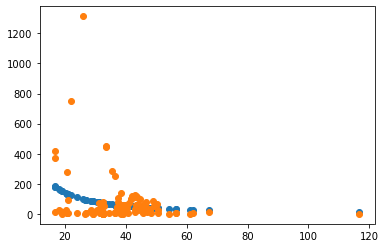

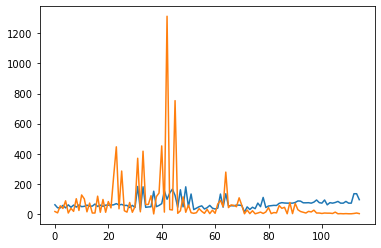

Product Solar
Channel Retail - Full Price
nit 1
Estimated params
[nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


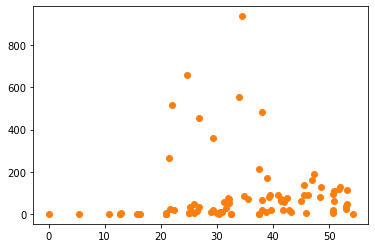

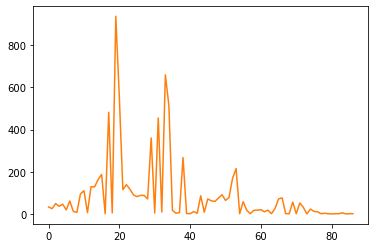

Product Nova
Channel UK Direct
nit 19617
Estimated params
[ 2.92332006 -0.30229779]
loss:  850.6807017907481


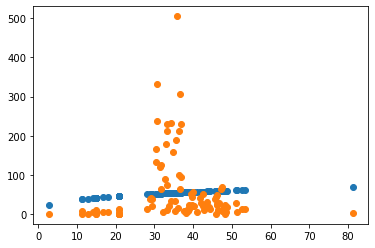

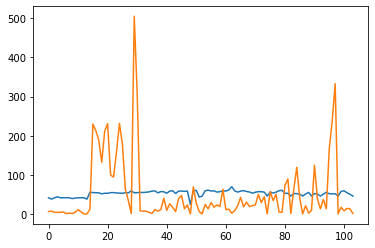

Product Nova
Channel Retail - Full Price
nit 35998
Estimated params
[ 2.08176618 -0.40129724]
loss:  291.25383349383156


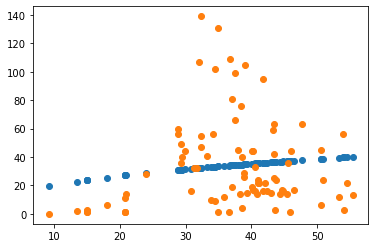

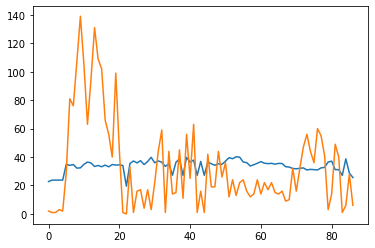

Product Tone
Channel UK Direct
nit 12389
Estimated params
[5.12612826 0.10355168]
loss:  3435.782704659675


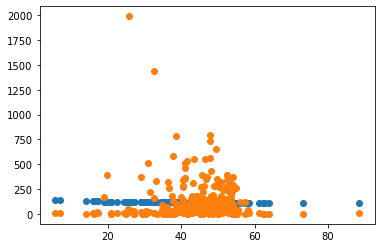

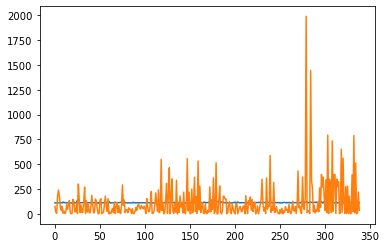

Product Tone
Channel Retail - Full Price
nit 1
Estimated params
[nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


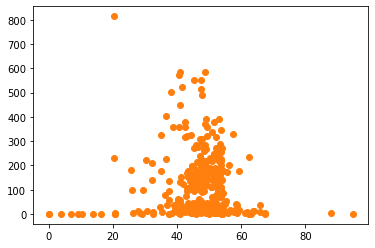

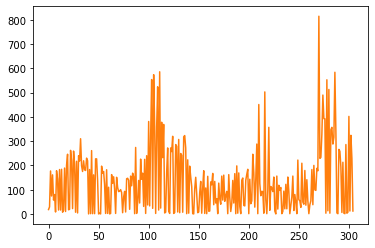

In [132]:
used_model = model1
for prod in products:
    for channel in ['UK Direct','Retail - Full Price']:
        #data_prod = data[(data['Description']==prod)&(data['Channel']==channel)].groupby(['Date'], as_index=False).agg(aggregations)
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]
        data_prod = data_prod[['Price','sales']]
        data_prod = data_prod.fillna(0)

        X = data_prod.values[:,:-1]
        d = data_prod.values[:,-1]
        w = 1*np.ones(2)
        w_o = 1*np.ones(2)
        loss = 10e10
        loss_o = 10e11
        Niterations = 1000000
        eta=0.0001
        nit=0
        print("Product",prod)
        print("Channel",channel)

        start_time = time.time()

        while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
            if loss>loss_o:
                eta = eta*0.7
                print('eta',eta) 
            w_o = w
            loss_o = loss

            gradients = my_training_gradient(d, X, w, model=used_model)
            w -= eta*gradients

            loss = my_autograd_loss(d,X,w,model=used_model)
            #print(nit, loss)

            #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
            #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
            nit+=1


        print("nit",nit)

        print("Estimated params")
        print(w)
        print('loss: ',my_autograd_loss(d,X,w,model=used_model))


        #print("Predicted values:")
        #print(used_model(X,w))

        plt.scatter(X[:,0],used_model(X,w))
        plt.scatter(X[:,0],d)
        plt.show()

        plt.plot(used_model(X,w))
        plt.plot(d)
        plt.show()

As expected the realtion between price and demand is not followed. As we have seen seasonality has strong effect on some product's demand. Hence we will try to remove this trend and seasonality and apply the model to the stationary component of the time series. For that we need to group the data by dates.

Product Suede And Nubuck Brush
Channel UK Direct
Product Suede And Nubuck Brush
Channel UK Direct
nit 49018
Estimated params
[ 4.28365946 -0.45154437  1.          1.          1.        ]
loss:  626.4499637753938


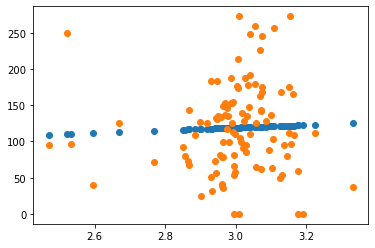

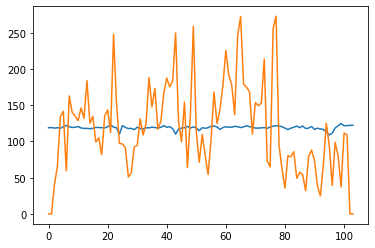

Product Suede And Nubuck Brush
Channel Retail - Full Price
Product Suede And Nubuck Brush
Channel Retail - Full Price
nit 5569
Estimated params
[6.1644511 0.7461088 1.        1.        1.       ]
loss:  817.5344631170192


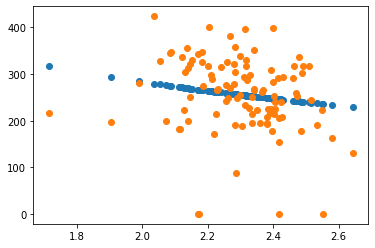

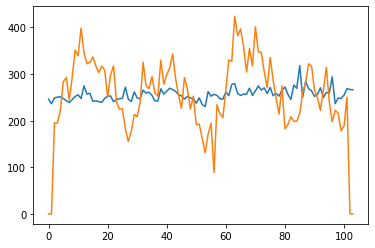

Product Hotter Women's Insoles
Channel UK Direct
Product Hotter Women's Insoles
Channel UK Direct
nit 80623
Estimated params
[3.75549254 0.21272743 1.         1.         1.        ]
loss:  162.6947685056663


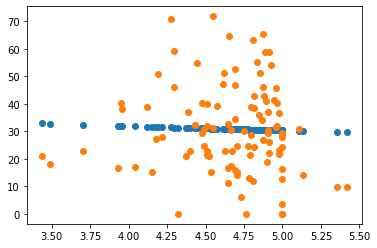

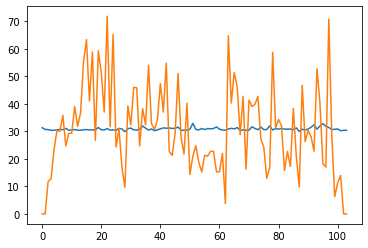

Product Hotter Women's Insoles
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
Product Hotter Women's Insoles
Channel Retail - Full Price
nit 132964
Estimated params
[11.19672972  3.45862595  1.          1.          1.        ]
loss:  1014.7795983824332


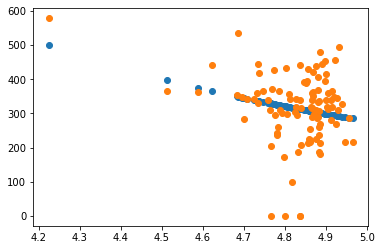

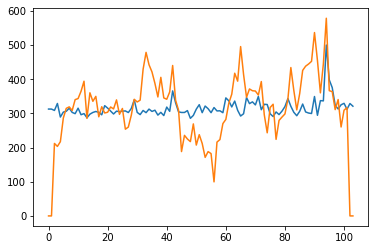

Product Footwear Cleaner
Channel UK Direct
Product Footwear Cleaner
Channel UK Direct
nit 61609
Estimated params
[ 3.9094718  -1.14185362  1.          1.          1.        ]
loss:  1359.6281779388794


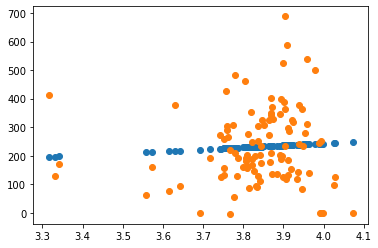

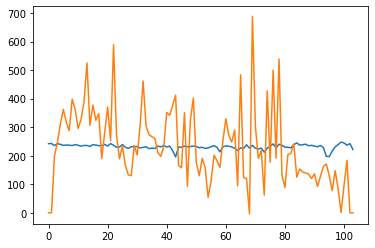

Product Footwear Cleaner
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
Product Footwear Cleaner
Channel Retail - Full Price
nit 92646
Estimated params
[-1.95734561 -5.94558051  1.          1.          1.        ]
loss:  1503.6543071795604


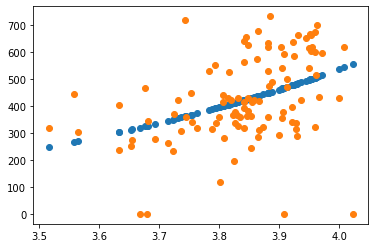

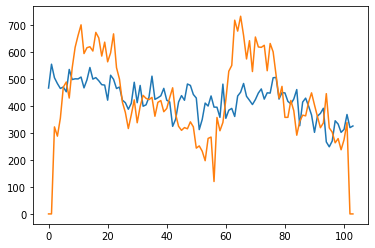

Product Renovating Cream
Channel UK Direct
Product Renovating Cream
Channel UK Direct
nit 25680
Estimated params
[10.07784901  3.5504519   1.          1.          1.        ]
loss:  1988.6356499637416


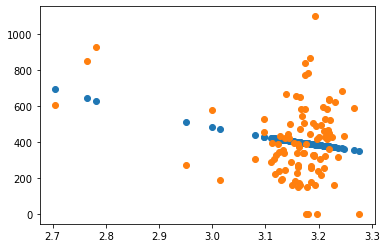

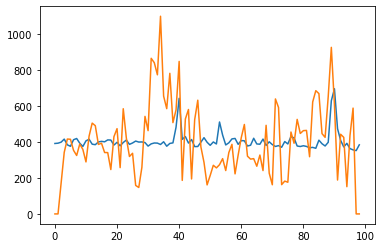

Product Renovating Cream
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
Product Renovating Cream
Channel Retail - Full Price
nit 38792
Estimated params
[10.92090934  3.43187182  1.          1.          1.        ]
loss:  4716.731184765187


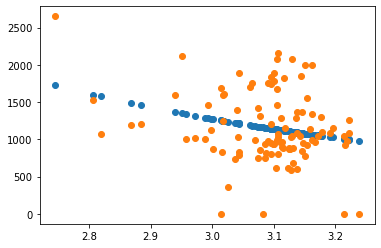

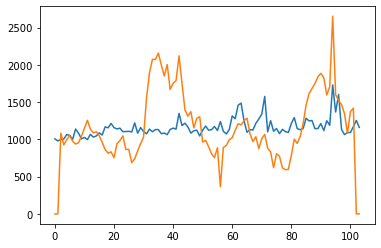

Product Wax Oil
Channel UK Direct


KeyboardInterrupt: 

In [133]:
#ALL PRODUCTS RESIDUAL
z=0
losses = np.zeros((13,14))
real = np.zeros((13,207))
used_model = model1

for prod in products:
    for channel in ['UK Direct','Retail - Full Price']:
        results = np.zeros((14,208))
        
        #We need to aggregate the results so we have a proper time series
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)].groupby(['Date'], as_index=False).agg(aggregations) 
        series = data_prod[['Date','sales']].groupby(['Date']).sum()
        
        result = seasonal_decompose(series, model='additive', period=5)
        residual = pd.DataFrame(result.resid)
        trend = pd.DataFrame(result.trend)
        trend = trend.rename(columns={'trend':'resid'})
        desc = residual.add(trend,fill_value=0)
        data_prod = data_prod.merge(desc, on='Date')
        data_prod = data_prod[['Price', 'resid']]
        data_prod = data_prod.fillna(0)
        
        X = data_prod.values[:,:-1]
        d = data_prod.values[:,-1]
        w = 1*np.ones(5)
        w_o = 1*np.ones(5)
        loss = 10e10
        loss_o = 10e11
        Niterations = 1000000
        eta=0.0001
        nit=0
        print("Product",prod)
        print("Channel",channel)

        start_time = time.time()

        while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
            if loss>loss_o:
                eta = eta*0.7
                print('eta',eta) 
            w_o = w
            loss_o = loss

            gradients = my_training_gradient(d, X, w, model=used_model)
            w -= eta*gradients

            loss = my_autograd_loss(d,X,w,model=used_model)
            #print(nit, loss)

            #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
            #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
            nit+=1

        print("Product",prod)
        print("Channel",channel)
        print("nit",nit)

        print("Estimated params")
        print(w)
        print('loss: ',my_autograd_loss(d,X,w,model=used_model))


        #print("Predicted values:")
        #print(used_model(X,w))

        plt.scatter(X[:,0],used_model(X,w))
        plt.scatter(X[:,0],d)
        plt.show()

        plt.plot(used_model(X,w))
        plt.plot(d)
        plt.show()



The model is basically predicting zero demand for all the prices. It is hard to belive the model can represent the real values based on the price plots. In order to improve our model we will try to add some variables and parameters to be learned.

## Feature addition Model

#### Synthetic data

In [118]:
#first define price
p = rand.uniform(20,50,50)
z = rand.uniform(0,1,50)
t = rand.uniform(0,1,50)
s = rand.uniform(0,10,50)

#create the dataframe
dades = {'p':p,'z':z, 't':t,'s':s}
sim2 = pd.DataFrame(data=dades)

#parameters of the data
gen_params = [5.5,1,1,0.02,0.1,1]

#define demand following model with noise parameter
sim2['d'] = model2_data(sim2.values,gen_params,0.1)

sim2.head(10)

p         z         t         s          d
0  38.647855  0.013932  0.540929  7.660835  17.832992
1  45.751652  0.115378  0.254911  6.776492  33.779422
2  48.505180  0.188578  0.218983  9.101295  23.700801
3  44.165857  0.880362  0.702662  8.636140   0.275518
4  46.251498  0.293483  0.060948  2.281132  45.188976
5  30.343633  0.216546  0.510638  5.854908  12.417255
6  29.567693  0.088617  0.890399  1.015790   7.526739
7  46.449627  0.485687  0.799079  8.318205   0.744569
8  47.773519  0.130599  0.017294  3.159570  94.726732
9  31.380481  0.646390  0.212389  8.241502   6.068287

nit 0  w:  [1.00000041 0.99999901 0.99999948 0.99999986 0.99999963 1.        ] grad [-0.0041065   0.00991913  0.00519963  0.0014104   0.00366217  0.        ] loss 239.8915460618806 time 0.0019996166229248047
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 2.8247524899999986e-06
eta 1.977326742999999e-06
eta 1.3841287200999992e-06
nit 1000000  w:  [5.40742561 1.23886098 1.11285009 0.00566226 0.05065539 1.        ] grad [-0.00608062 -0.2459503  -0.23598925 -0.00124076  0.73053671  0.        ] loss 21.630308361573388 time 464.74064540863037
nit 2000000  w:  [ 5.41176012  1.46422841  1.33366208  0.00673262 -0.51535921  1.        ] grad [-0.00090687 -0.06952234 -0.06971628 -0.00030198  0.14762894  0.        ] loss 21.275598704721897 time 947.2099289894104
nit 3000000  w:  [ 5.41222152  1.50334058  1.37306563  0.0068

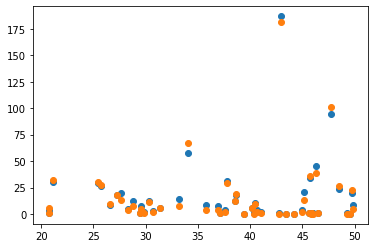

In [119]:
X = sim2.values[:,:-1]
d = sim2.values[:,-1]
w =np.ones(6)
w_o =np.ones(6)
loss = 10e10
loss_o = 10e11
Niterations = 10000000
eta=0.0001
nit=0
used_model = model2

start_time = time.time()

while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
    if loss>loss_o:
        eta = eta*0.7
        print('eta',eta) 
    w_o = w
    loss_o = loss
    
    gradients = my_training_gradient(d, X, w, model=used_model)
    w -= eta*gradients
    
    loss = my_autograd_loss(d,X,w,model=used_model)
    #print(nit, loss)
    
    if nit % 1000000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
    nit+=1

print("nit",nit)

print("Generative params")
print(gen_params)
print("Estimated params")
print(w)
print('loss: ',my_autograd_loss(d,X,w,model=used_model))

print("Real values:")
print(d)
print("Predicted values:")
d_p = used_model(X,w)
print(d_p)
plt.scatter(X[:,0],d)
plt.scatter(X[:,0],d_p)

It worked, anyhow the model is quite sensitive to the data and for certain combinations we end up into a local minima where all the results are equal to zero. This already suggest that we might need to initialize our model for different starting points to avoid obtaining local minima.

In [25]:
#first define price
p = rand.uniform(20,50,50)
z = rand.uniform(0,1,50)
t = rand.uniform(0,1,50)
s = rand.uniform(0,10,50)

#create the dataframe
dades = {'p':p,'z':z, 't':t,'s':s}
sim2 = pd.DataFrame(data=dades)

#parameters of the data
gen_params = [5.5,1,1,0.02,0.1,0.1]

#define demand following model with noise parameter
sim2['d'] = model2_data(sim2.values,gen_params,0.09)

sim2.head(10)

p         z         t         s          d
0  32.286412  0.310861  0.181686  3.995645  31.172800
1  22.632317  0.351236  0.143291  1.530100  45.190560
2  44.572270  0.921290  0.782394  5.795574   0.205943
3  35.444481  0.286114  0.854690  8.117735   2.091039
4  41.323241  0.898718  0.542707  0.213868   0.950244
5  22.979112  0.847483  0.680562  2.287737   1.504010
6  44.404017  0.184672  0.751875  6.448119   3.883097
7  25.208201  0.340727  0.814508  1.253971   4.912686
8  38.385850  0.530901  0.997305  8.377224   0.423875
9  38.975642  0.640484  0.237591  2.084321   7.685277

nit 0  w:  [1.00000054 0.99999981 0.99999939 0.99999779 0.99999934 1.        ] grad [-0.00538134  0.00194517  0.00612947  0.02210513  0.0065766   0.        ] loss 193.28366541255613 time 0.0009975433349609375
eta 7e-05
nit 88669
Generative params
[5.5, 1, 1, 0.02, 0.1, 0.1]
Estimated params
[ 0.71096357  1.13749302  1.18122031 21.22127782  0.02807227  1.        ]
loss:  193.28904716876374
Real values:
[ 31.17280017  45.1905603    0.20594323   2.09103928   0.9502445
   1.50400967   3.88309656   4.9126864    0.42387488   7.68527689
  23.80493678  38.97978229  20.45061909   5.67337015   0.5843661
   6.09448197   2.14283757   5.98398812  23.70156851  82.69736368
   4.97936249   3.79833886   0.37156414   6.29562958   4.33712478
   8.21770668   1.25161539  21.74012946   9.70891773   1.58388891
   1.42589064  11.71752527  79.55902728   2.68510557   6.74629703
  36.6250058    1.50966043   3.28627675   0.22091555   7.57568516
   6.91016771   2.64853274   1.06220135  21.73450943  10.16748507
  5

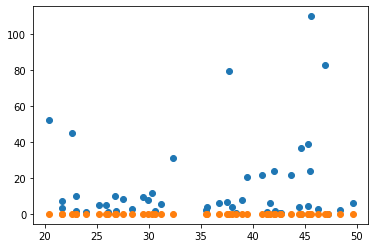

In [26]:
X = sim2.values[:,:-1]
d = sim2.values[:,-1]
w =np.ones(6)
w_o =np.ones(6)
loss = 10e10
loss_o = 10e11
Niterations = 10000000
eta=0.0001
nit=0
used_model = model2

start_time = time.time()

while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
    if loss>loss_o:
        eta = eta*0.7
        print('eta',eta) 
    w_o = w
    loss_o = loss
    
    gradients = my_training_gradient(d, X, w, model=used_model)
    w -= eta*gradients
    
    loss = my_autograd_loss(d,X,w,model=used_model)
    #print(nit, loss)
    
    if nit % 1000000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
    nit+=1

print("nit",nit)

print("Generative params")
print(gen_params)
print("Estimated params")
print(w)
print('loss: ',my_autograd_loss(d,X,w,model=used_model))

print("Real values:")
print(d)
print("Predicted values:")
d_p = used_model(X,w)
print(d_p)
plt.scatter(X[:,0],d)
plt.scatter(X[:,0],d_p)

### Real Data

Product Suede And Nubuck Brush
Channel UK Direct
eta 7e-05
eta 4.899999999999999e-05
nit 438071
Estimated params
[ 4.70052035 -3.64223944  1.31608093 -3.64369609 -1.03954961]
loss:  551.0642242073078


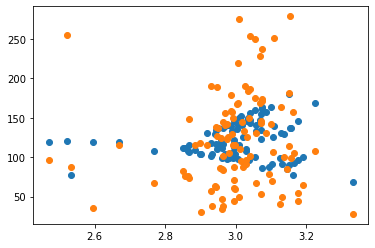

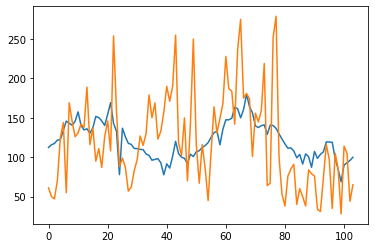

Product Suede And Nubuck Brush
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
nit 27519
Estimated params
[ 4.82333539 -0.14565053  0.06822203 -1.02865874  0.01811882]
loss:  557.8770080651323


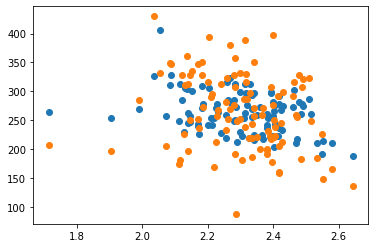

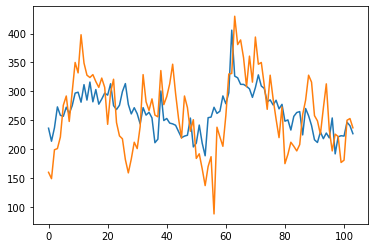

Product Hotter Women's Insoles
Channel UK Direct
nit 177718
Estimated params
[ 3.30214491 -0.50107975  1.33936625 -3.59588852 -1.37127471]
loss:  142.38066014218768


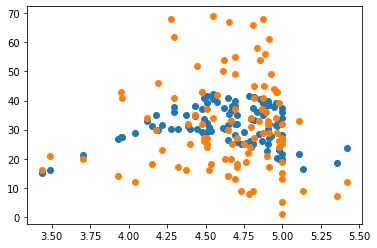

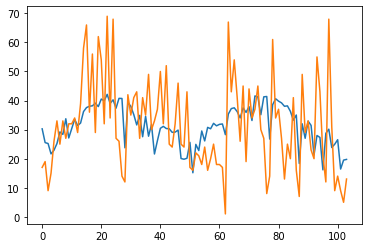

Product Hotter Women's Insoles
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
nit 1000000
Estimated params
[ 5.68930967  0.02152366  0.02258157 -0.11953542  3.86413839]
loss:  731.6911767849729


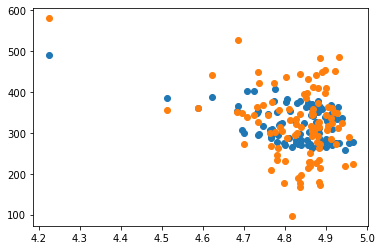

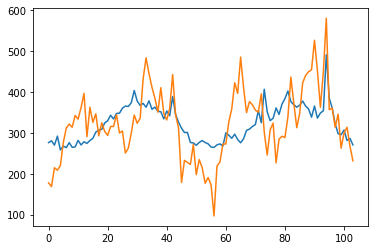

Product Footwear Cleaner
Channel UK Direct
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
nit 1000000
Estimated params
[  5.36450953  -8.85094141   4.35317256 -10.72374012  -1.32079005]
loss:  1132.9276111940176


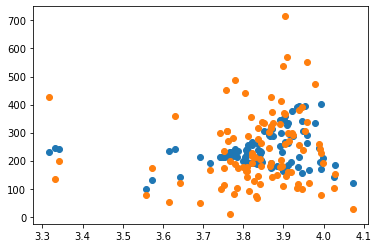

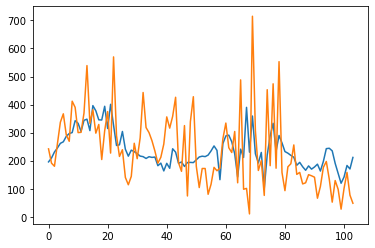

Product Footwear Cleaner
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
nit 1000000
Estimated params
[ 5.8718122  -3.07508599  2.39083745 -8.0721815  -1.25232411]
loss:  807.0951285917258


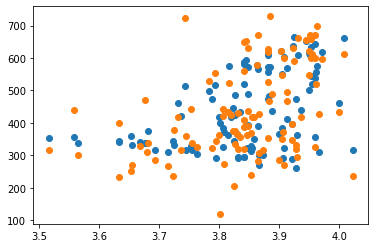

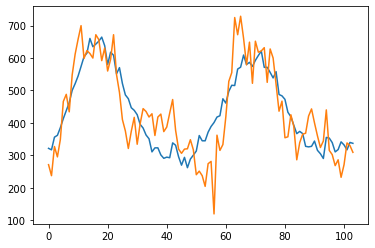

Product Renovating Cream
Channel UK Direct
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
nit 1000000
Estimated params
[ 5.88688266  0.0539975   0.00871616 -0.10825584  5.08208762]
loss:  1617.2581298307512


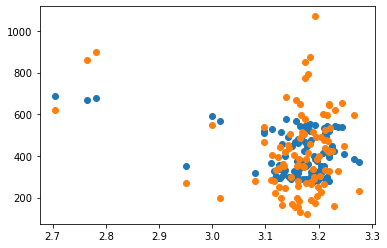

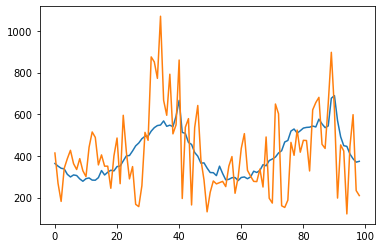

Product Renovating Cream
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 2.8247524899999986e-06
eta 1.977326742999999e-06
nit 1000000
Estimated params
[ 6.8724825   0.06838705 -0.01851755 -0.18801064  4.18615614]
loss:  2808.218607797565


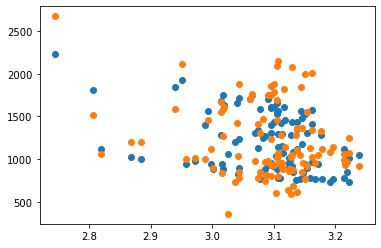

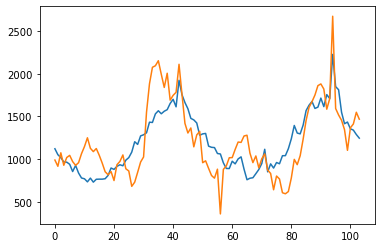

Product Wax Oil
Channel UK Direct
nit 624218
Estimated params
[ 1.28042022  0.89561794 -0.7078515  -1.93015917 -0.88893231]
loss:  30.41479633305359


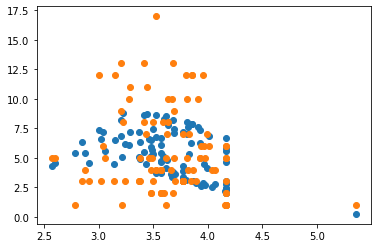

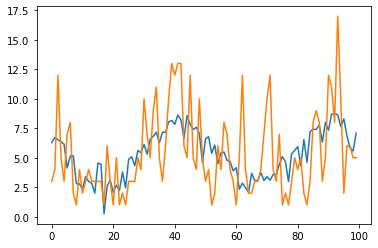

Product Wax Oil
Channel Retail - Full Price
eta 7e-05
nit 1000000
Estimated params
[ 3.40849226  0.06551953 -0.02492306  0.03282093  6.06023349]
loss:  153.50638461781168


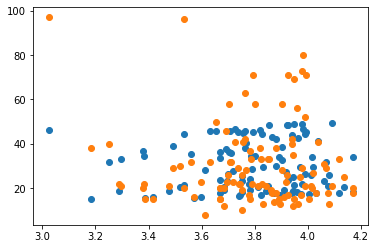

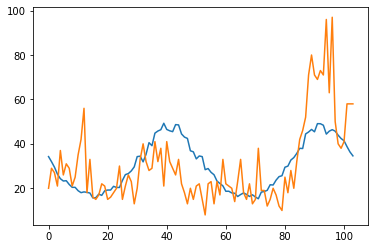

Product Shake
Channel UK Direct
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


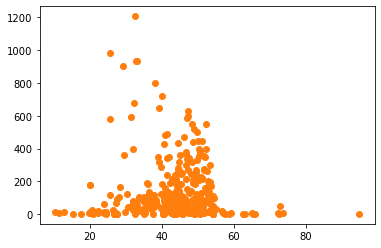

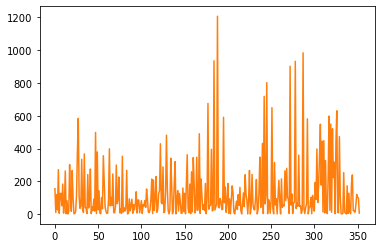

Product Shake
Channel Retail - Full Price
nit 1
Estimated params
[-1.87961482e+116              nan              nan              nan
 -1.03892411e+118]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),


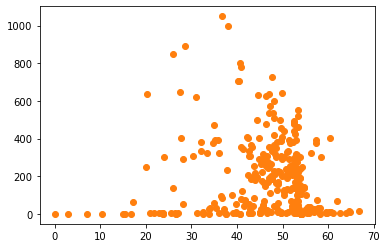

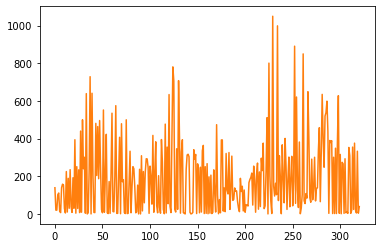

Product Rutland GTX
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),


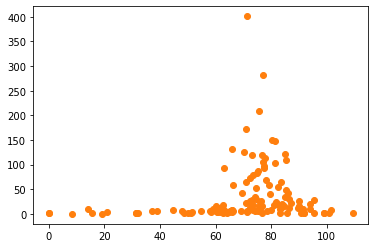

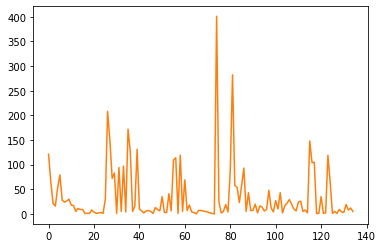

Product Rutland GTX
Channel Retail - Full Price
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


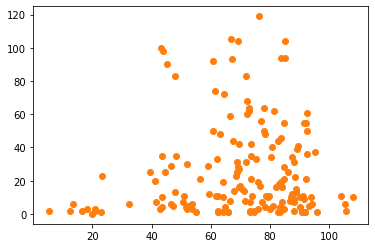

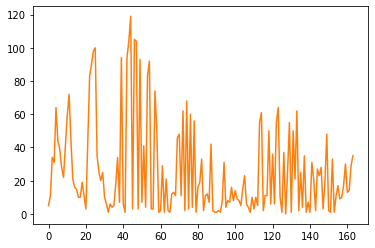

Product Laurel
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


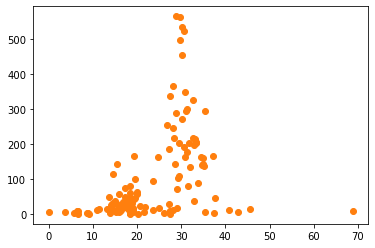

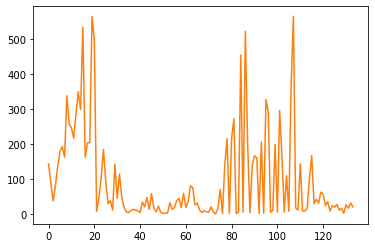

Product Laurel
Channel Retail - Full Price
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


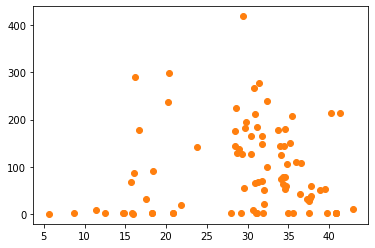

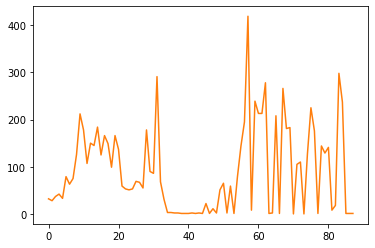

Product Leanne
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


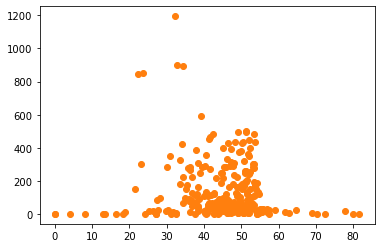

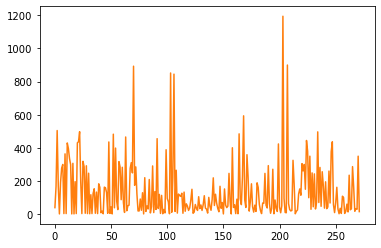

Product Leanne
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


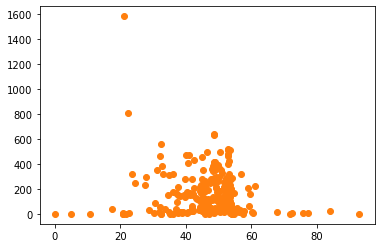

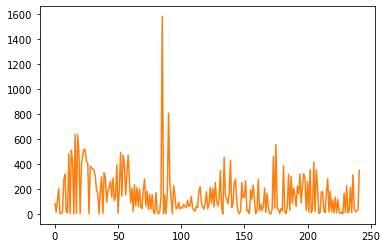

Product Solar
Channel UK Direct
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


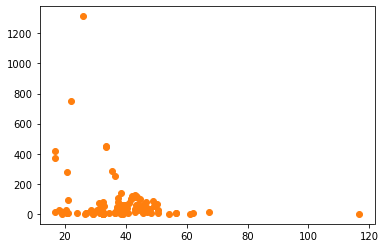

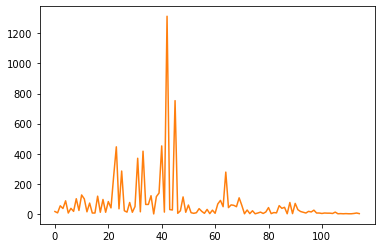

Product Solar
Channel Retail - Full Price
nit 1
Estimated params
[ -89370.7646449               nan              nan              nan
 -517864.32581864]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),


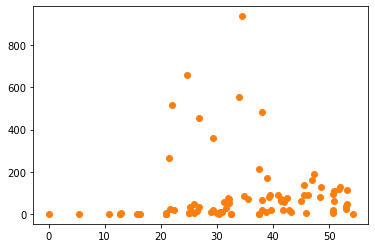

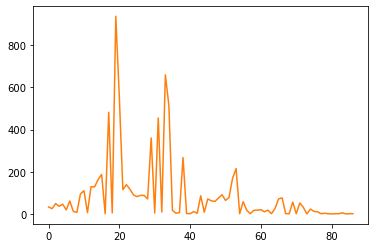

Product Nova
Channel UK Direct
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


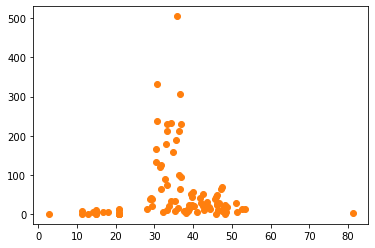

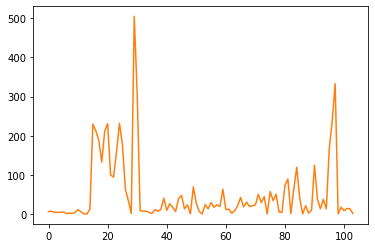

Product Nova
Channel Retail - Full Price
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


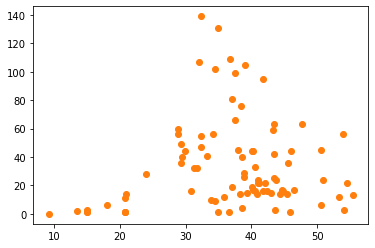

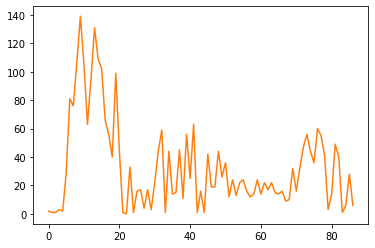

Product Tone
Channel UK Direct
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


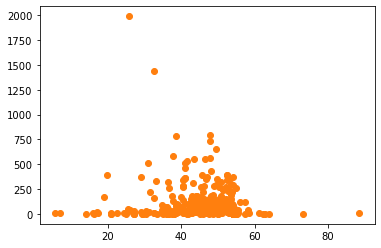

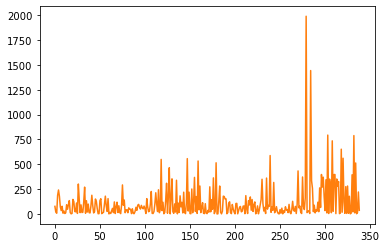

Product Tone
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


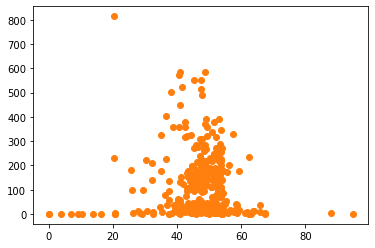

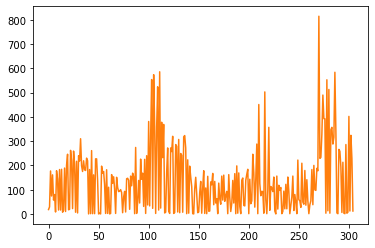

In [134]:
used_model = model2

for prod in products:
    for channel in ['UK Direct','Retail - Full Price']:
        #data_prod = data[(data['Description']==prod)&(data['Channel']==channel)].groupby(['Date'], as_index=False).agg(aggregations)
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]
        data_prod = data_prod[['Price','Week_sin','Week_cos','Discount','sales']]
        data_prod = data_prod.fillna(0)

        X = data_prod.values[:,:-1]
        d = data_prod.values[:,-1]
        w = 1*np.ones(5)
        w_o = 1*np.ones(5)
        loss = 10e10
        loss_o = 10e11
        Niterations = 1000000
        eta=0.0001
        nit=0
        print("Product",prod)
        print("Channel",channel)

        start_time = time.time()

        while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
            if loss>loss_o:
                eta = eta*0.7
                print('eta',eta) 
            w_o = w
            loss_o = loss

            gradients = my_training_gradient(d, X, w, model=used_model)
            w -= eta*gradients

            loss = my_autograd_loss(d,X,w,model=used_model)
            #print(nit, loss)

            #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
            #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
            nit+=1


        print("nit",nit)

        print("Estimated params")
        print(w)
        print('loss: ',my_autograd_loss(d,X,w,model=used_model))


        #print("Predicted values:")
        #print(used_model(X,w))

        plt.scatter(X[:,0],used_model(X,w))
        plt.scatter(X[:,0],d)
        plt.show()

        plt.plot(used_model(X,w))
        plt.plot(d)
        plt.show()

We also try with different features

Product Suede And Nubuck Brush
Channel UK Direct
nit 1000000
Estimated params
[7.84792751 1.         1.93408321 4.57186696 4.18514912]
loss:  1364.290871714055


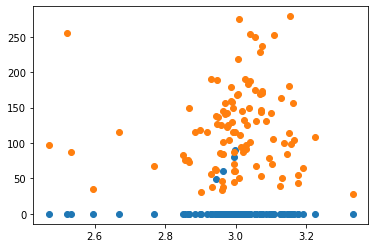

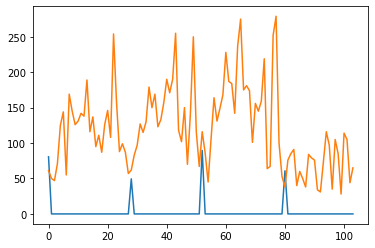

Product Suede And Nubuck Brush
Channel Retail - Full Price
nit 1000000
Estimated params
[ 4.85997435  1.         -0.37313827  0.09590841  0.23288927]
loss:  2750.9031049073087


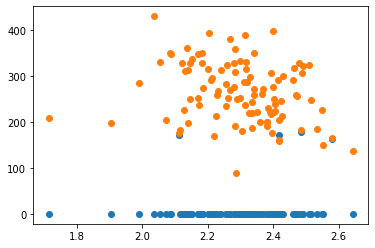

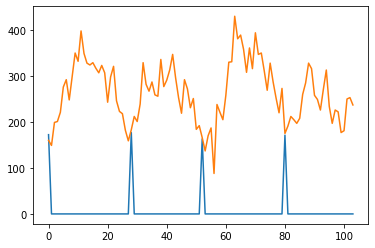

Product Hotter Women's Insoles
Channel UK Direct
eta 7e-05
eta 4.899999999999999e-05
nit 23001
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


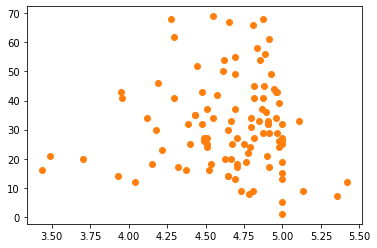

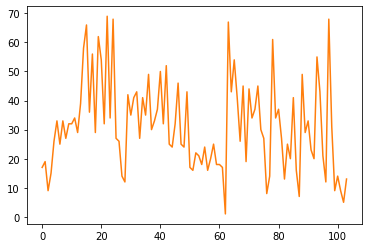

Product Hotter Women's Insoles
Channel Retail - Full Price
nit 308410
Estimated params
[ 4.55480197  1.         -2.08043547 -0.91544227  1.56661673]
loss:  3373.567587478688


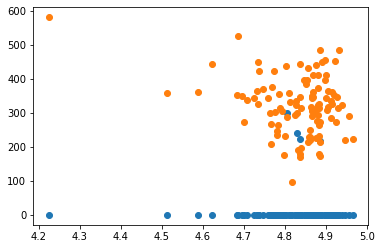

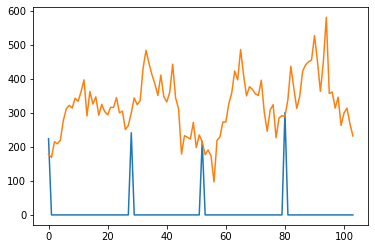

Product Footwear Cleaner
Channel UK Direct
nit 1000000
Estimated params
[6.15963945 0.99999912 0.90969372 3.36016304 2.60319107]
loss:  2731.9575188482445


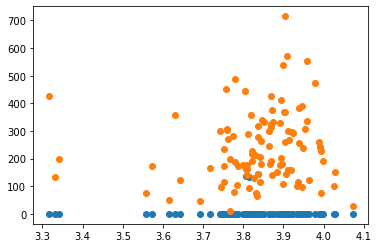

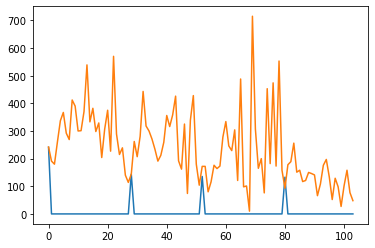

Product Footwear Cleaner
Channel Retail - Full Price
nit 1000000
Estimated params
[ 5.46819778  1.         -1.21061801  0.69768347  1.13084888]
loss:  4631.613938646335


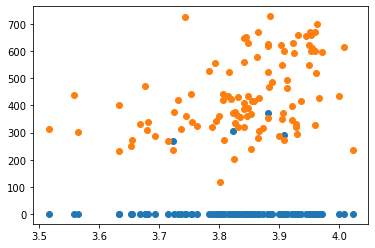

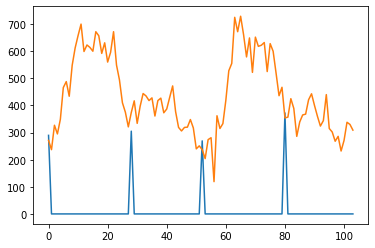

Product Renovating Cream
Channel UK Direct
nit 1000000
Estimated params
[ 3.86049914  1.         -3.24070446 -0.04286612  2.65584575]
loss:  4515.296721644557


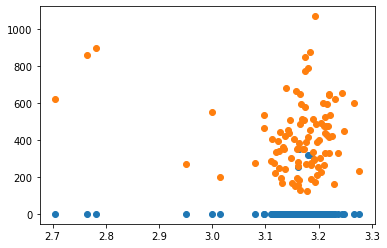

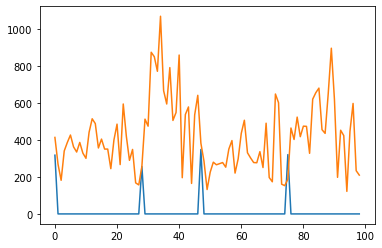

Product Renovating Cream
Channel Retail - Full Price
nit 1000000
Estimated params
[ 7.06943426e+00  1.00000000e+00  9.99762635e-01 -1.79305144e-03
  8.70193807e-01]
loss:  12916.78877613028


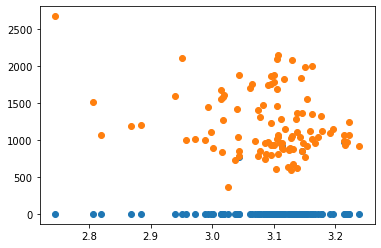

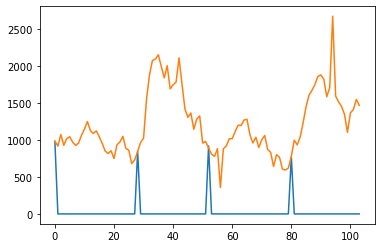

Product Wax Oil
Channel UK Direct
eta 7e-05
nit 1000000
Estimated params
[ 0.81171459 -0.13181635 -1.85136325 -1.2766407  -0.74859557]
loss:  29.714818674274156


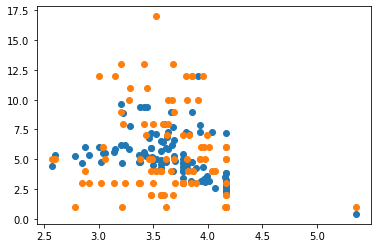

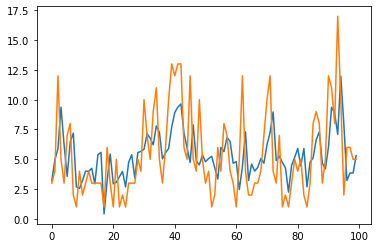

Product Wax Oil
Channel Retail - Full Price
nit 1000000
Estimated params
[3.48215538 0.99993117 0.04223949 1.2766247  0.9190691 ]
loss:  360.2327005977711


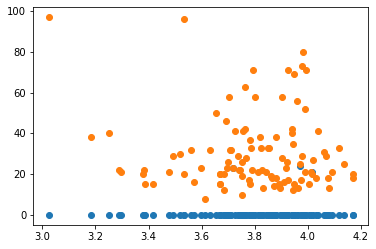

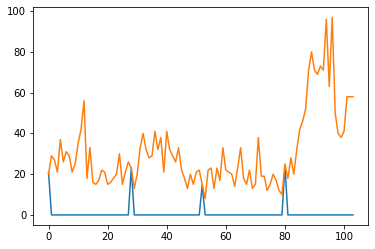

Product Shake
Channel UK Direct
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


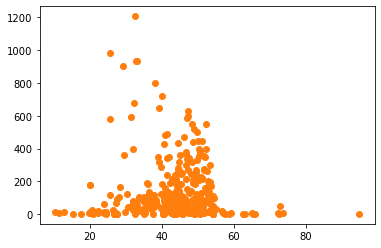

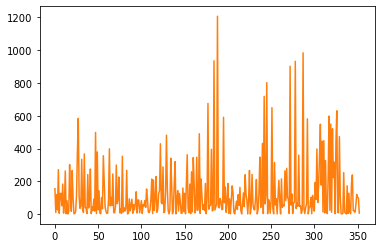

Product Shake
Channel Retail - Full Price
nit 1
Estimated params
[-5.33128858e+098              nan              nan              nan
 -2.51530195e+100]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),


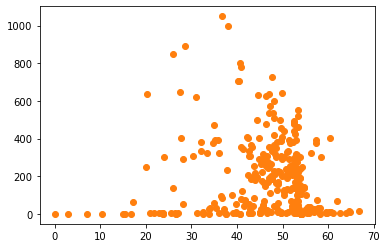

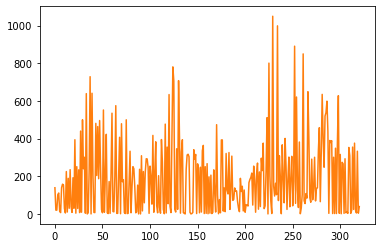

Product Rutland GTX
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


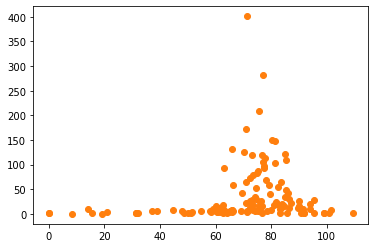

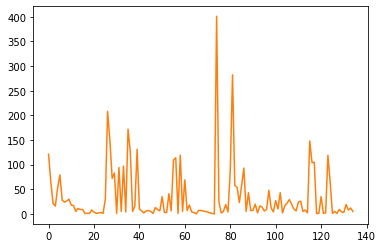

Product Rutland GTX
Channel Retail - Full Price
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


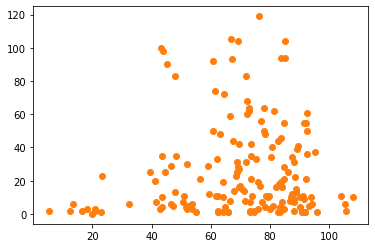

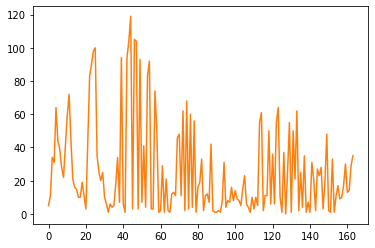

Product Laurel
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


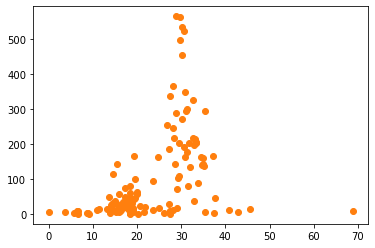

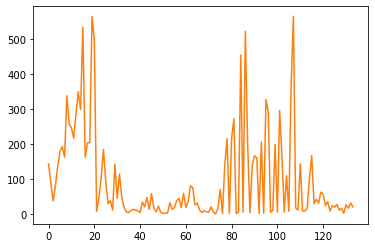

Product Laurel
Channel Retail - Full Price
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


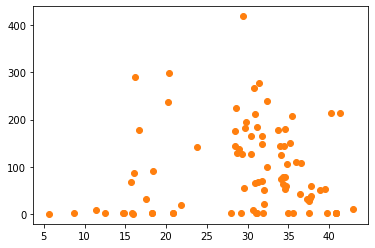

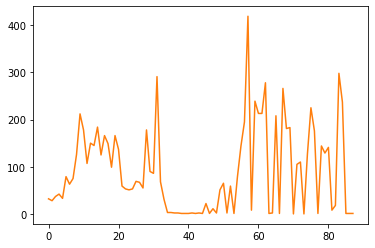

Product Leanne
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


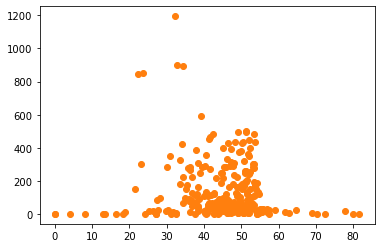

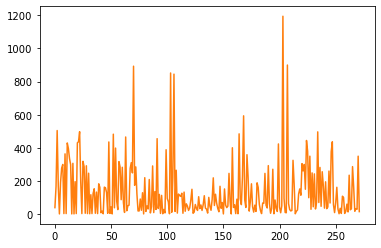

Product Leanne
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


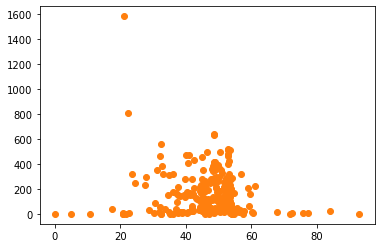

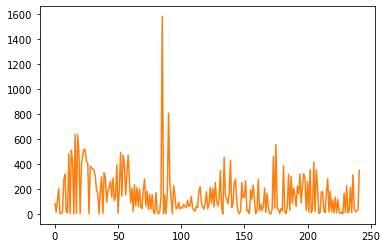

Product Solar
Channel UK Direct
eta 7e-05
nit 2
Estimated params
[1. 1. 1. 1. 1.]
loss:  inf


C:\Users\JAELFR~1\AppData\Local\Temp/ipykernel_17220/1469958002.py:24: RuntimeWarning: invalid value encountered in double_scalars
  while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:


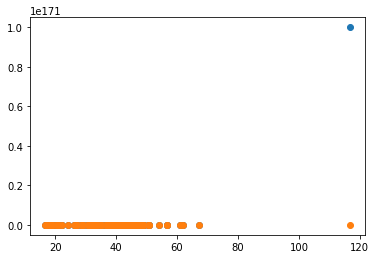

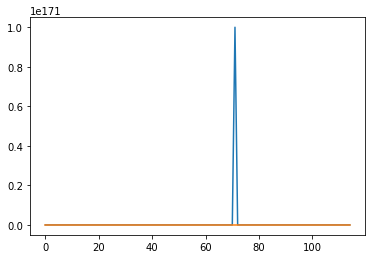

Product Solar
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


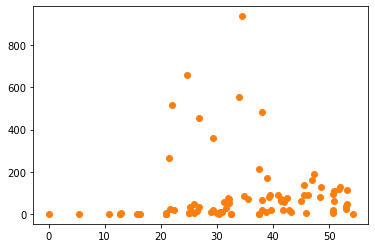

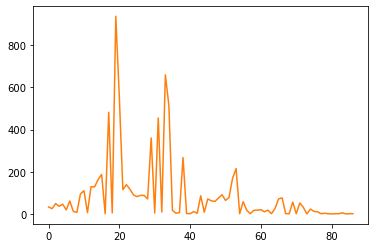

Product Nova
Channel UK Direct
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


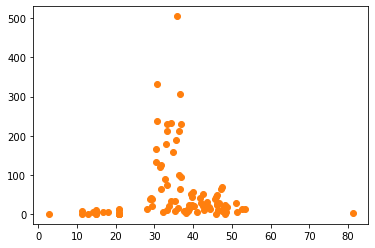

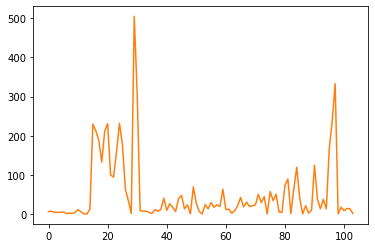

Product Nova
Channel Retail - Full Price
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


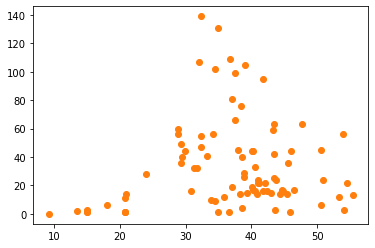

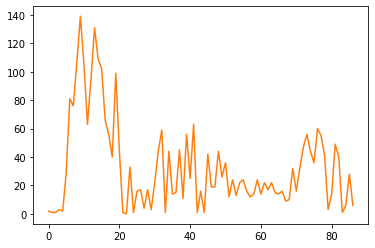

Product Tone
Channel UK Direct
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


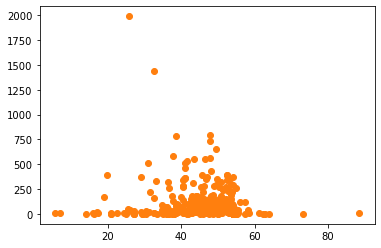

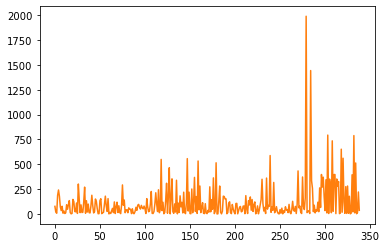

Product Tone
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),


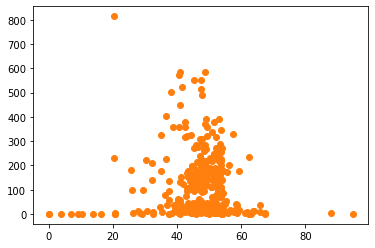

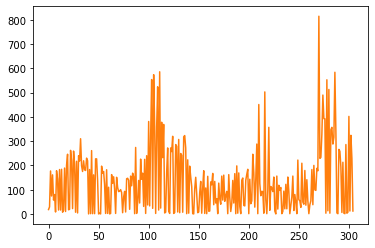

In [135]:
#ALL PRODUCTS
used_model = model2
for prod in products:
    for channel in ['UK Direct','Retail - Full Price']:
        #data_prod = data[(data['Description']==prod)&(data['Channel']==channel)].groupby(['Date'], as_index=False).agg(aggregations)
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]
        data_prod = data_prod[['Price','prev_sales','Discount','Markdown','sales']]
        data_prod = data_prod.fillna(0)

        X = data_prod.values[:,:-1]
        d = data_prod.values[:,-1]
        w = 1*np.ones(5)
        w_o = 1*np.ones(5)
        loss = 10e10
        loss_o = 10e11
        Niterations = 1000000
        eta=0.0001
        nit=0
        print("Product",prod)
        print("Channel",channel)

        start_time = time.time()

        while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
            if loss>loss_o:
                eta = eta*0.7
                print('eta',eta) 
            w_o = w
            loss_o = loss

            gradients = my_training_gradient(d, X, w, model=used_model)
            w -= eta*gradients

            loss = my_autograd_loss(d,X,w,model=used_model)
            #print(nit, loss)

            #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
            #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
            nit+=1


        print("nit",nit)

        print("Estimated params")
        print(w)
        print('loss: ',my_autograd_loss(d,X,w,model=used_model))


        #print("Predicted values:")
        #print(used_model(X,w))

        plt.scatter(X[:,0],used_model(X,w))
        plt.scatter(X[:,0],d)
        plt.show()

        plt.plot(used_model(X,w))
        plt.plot(d)
        plt.show()


Product Suede And Nubuck Brush
Channel UK Direct
nit 1000000
Estimated params
[ 3.83970025  1.          1.33776564 -0.4705128   1.006686  ]
loss:  1364.3054890396916


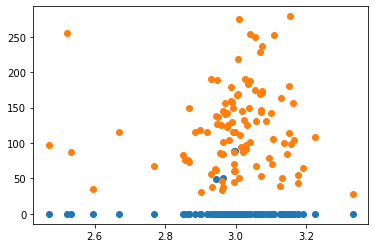

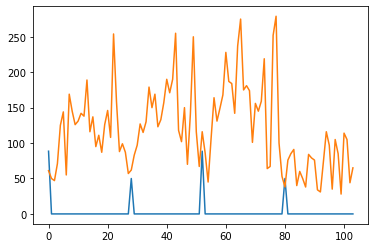

Product Suede And Nubuck Brush
Channel Retail - Full Price
nit 1000000
Estimated params
[ 4.46523529  1.          1.77681016 -0.41898318  2.20068889]
loss:  2750.866419330655


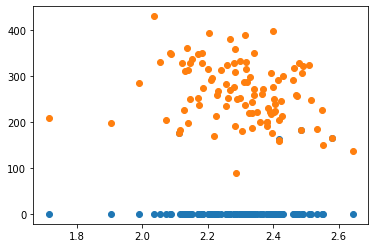

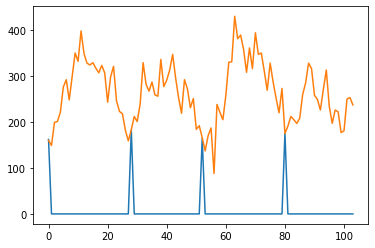

Product Hotter Women's Insoles
Channel UK Direct
eta 7e-05
eta 4.899999999999999e-05
nit 77367
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


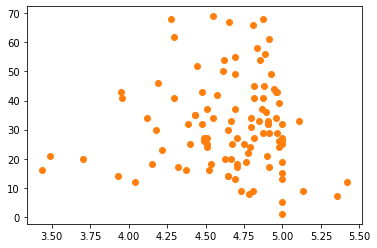

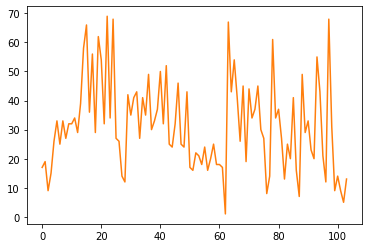

Product Hotter Women's Insoles
Channel Retail - Full Price
nit 1000000
Estimated params
[ 4.76363381  1.          2.01917826 -0.42482119  1.31865145]
loss:  3372.831312475226


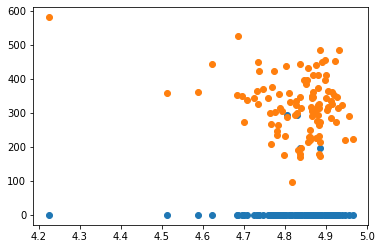

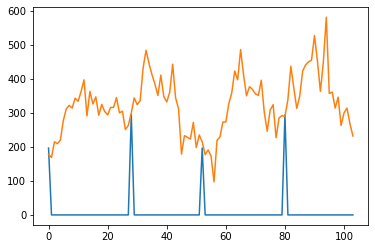

Product Footwear Cleaner
Channel UK Direct
nit 1000000
Estimated params
[ 4.35059922  0.99999993  2.83952322 -0.846548    0.61679131]
loss:  2732.046141224924


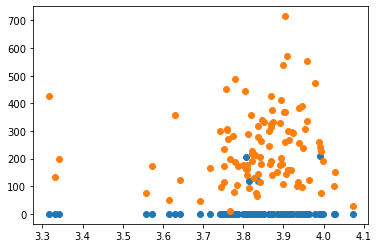

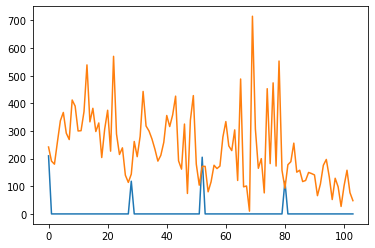

Product Footwear Cleaner
Channel Retail - Full Price
nit 1000000
Estimated params
[ 4.89016815  1.          2.14449973 -0.46944879  1.78271918]
loss:  4630.993678033748


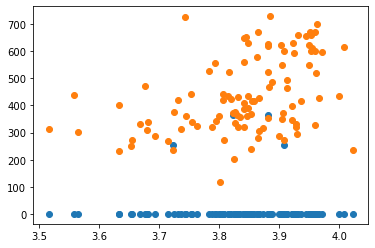

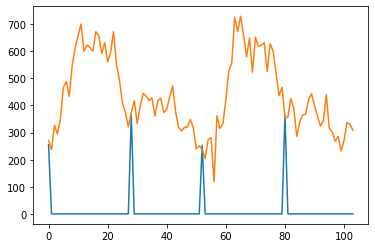

Product Renovating Cream
Channel UK Direct
nit 1000000
Estimated params
[ 5.11690953  1.          1.7702893  -0.55286169  1.44195736]
loss:  4512.502157192171


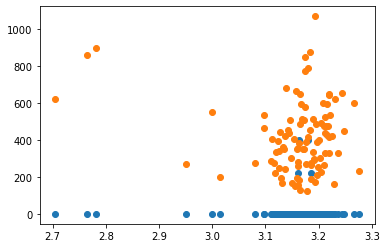

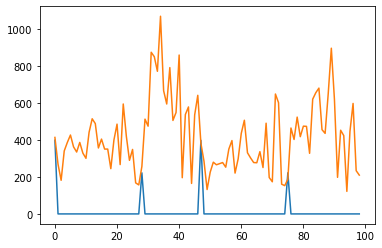

Product Renovating Cream
Channel Retail - Full Price
nit 1000000
Estimated params
[ 6.2582676   1.          2.34257478 -0.61862803  0.62230739]
loss:  12916.958572015088


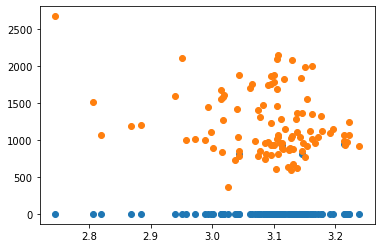

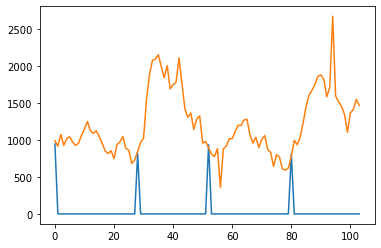

Product Wax Oil
Channel UK Direct
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
nit 1000000
Estimated params
[ 1.38422037 -0.01281683  0.07945625 -0.03978364  2.38642189]
loss:  29.020776399390932


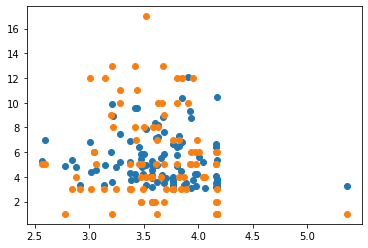

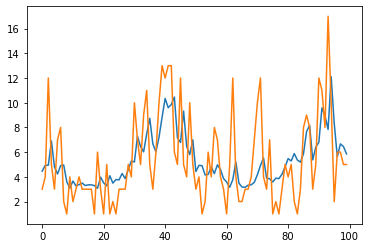

Product Wax Oil
Channel Retail - Full Price
nit 1000000
Estimated params
[ 2.68310971  0.99997973  1.23990884 -0.23109813  0.8686195 ]
loss:  360.2494136287743


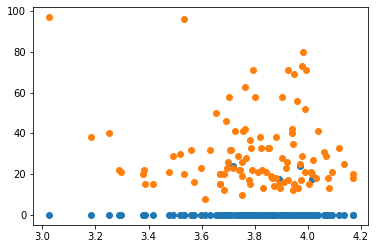

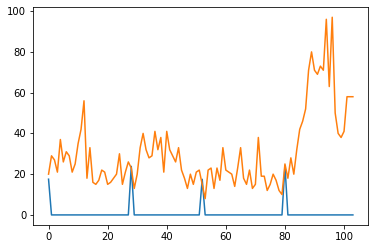

Product Shake
Channel UK Direct
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


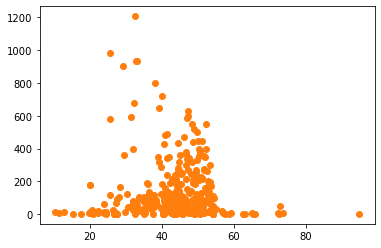

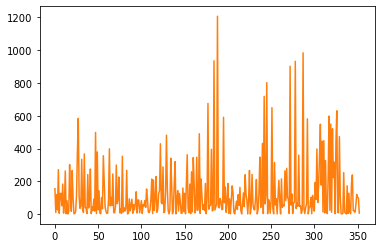

Product Shake
Channel Retail - Full Price
nit 1
Estimated params
[-3.17869422e+18             nan             nan             nan
 -3.88126749e+19]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),


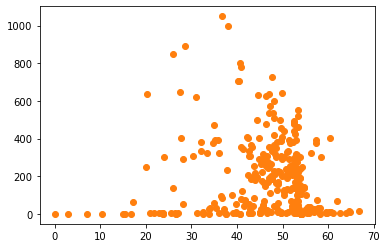

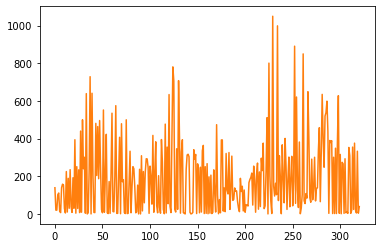

Product Rutland GTX
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


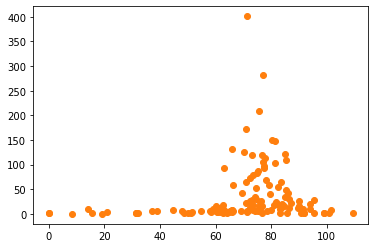

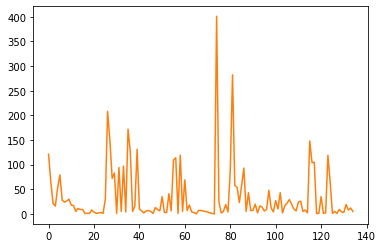

Product Rutland GTX
Channel Retail - Full Price
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


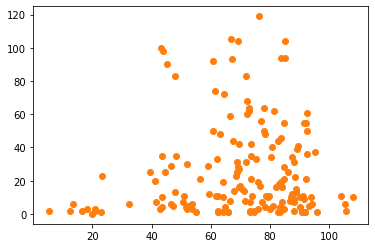

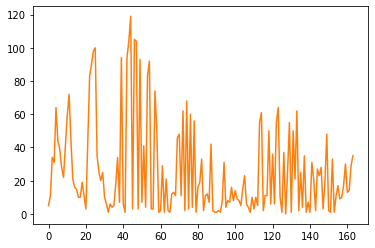

Product Laurel
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


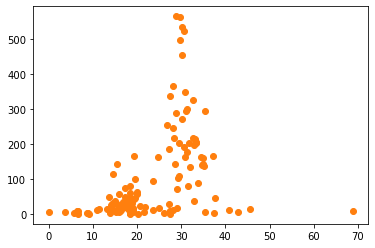

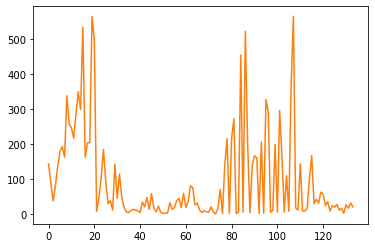

Product Laurel
Channel Retail - Full Price
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


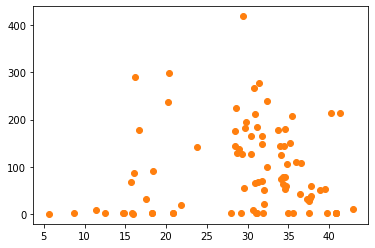

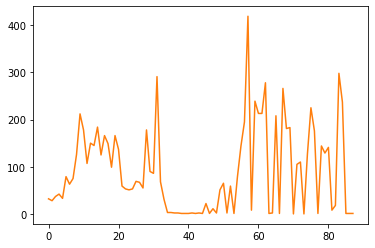

Product Leanne
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),


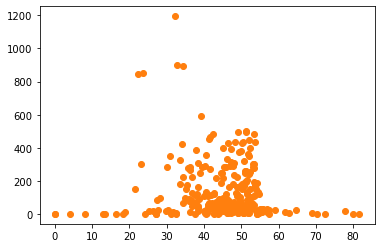

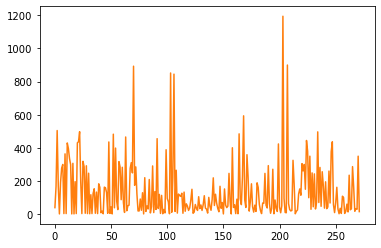

Product Leanne
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


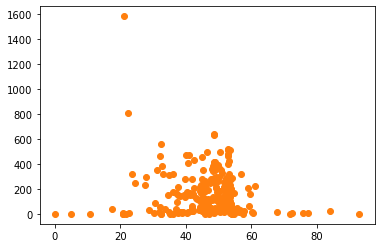

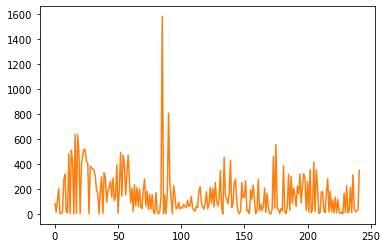

Product Solar
Channel UK Direct
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


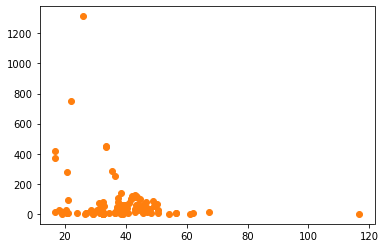

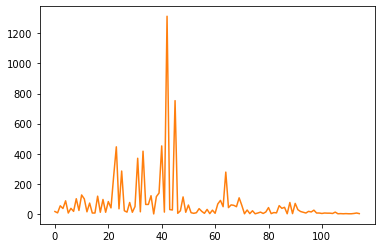

Product Solar
Channel Retail - Full Price
nit 1
Estimated params
[-104.2867843          nan          nan          nan -362.2507049]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),


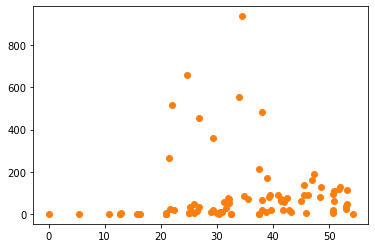

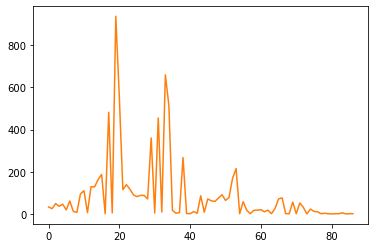

Product Nova
Channel UK Direct
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


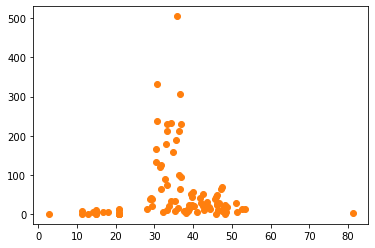

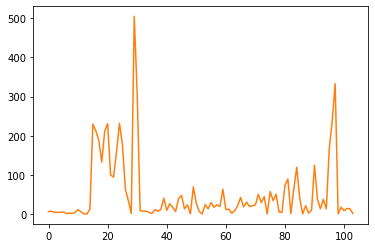

Product Nova
Channel Retail - Full Price
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


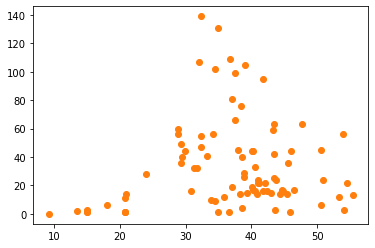

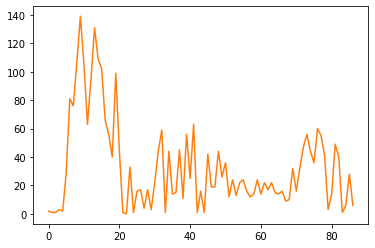

Product Tone
Channel UK Direct
eta 7e-05
nit 2
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


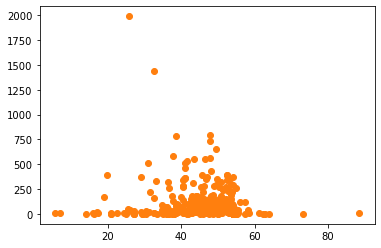

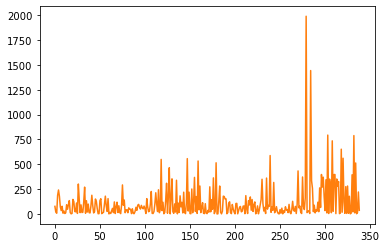

Product Tone
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),


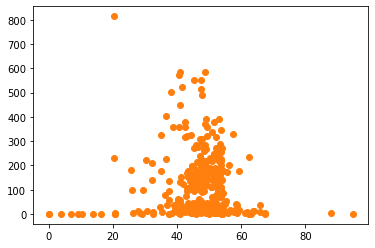

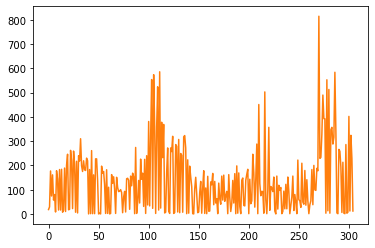

In [136]:
#ALL PRODUCTS
used_model = model2

for prod in products:
    for channel in ['UK Direct','Retail - Full Price']:
        #data_prod = data[(data['Description']==prod)&(data['Channel']==channel)].groupby(['Date'], as_index=False).agg(aggregations)
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]
        data_prod = data_prod[['Price','prev_sales','Week_sin','Week_cos','sales']]
        data_prod = data_prod.fillna(0)

        X = data_prod.values[:,:-1]
        d = data_prod.values[:,-1]
        w = 1*np.ones(5)
        w_o = 1*np.ones(5)
        loss = 10e10
        loss_o = 10e11
        Niterations = 1000000
        eta=0.0001
        nit=0
        print("Product",prod)
        print("Channel",channel)

        start_time = time.time()

        while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
            if loss>loss_o:
                eta = eta*0.7
                print('eta',eta) 
            w_o = w
            loss_o = loss

            gradients = my_training_gradient(d, X, w, model=used_model)
            w -= eta*gradients

            loss = my_autograd_loss(d,X,w,model=used_model)
            #print(nit, loss)

            #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
            #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
            nit+=1


        print("nit",nit)

        print("Estimated params")
        print(w)
        print('loss: ',my_autograd_loss(d,X,w,model=used_model))


        #print("Predicted values:")
        #print(used_model(X,w))

        plt.scatter(X[:,0],used_model(X,w))
        plt.scatter(X[:,0],d)
        plt.show()

        plt.plot(used_model(X,w))
        plt.plot(d)
        plt.show()


Looks that is arriving to a local minima instead of a global one. To try to find the global one we will try to start with different initializatrions

Product Suede And Nubuck Brush
Channel UK Direct
eta 7e-05
eta 4.899999999999999e-05
loss:  551.0642242068193
initialization:  -3.0
w:  [ 4.70052033 -3.64224087  1.31608157 -3.6436995  -1.03954964 -3.        ]


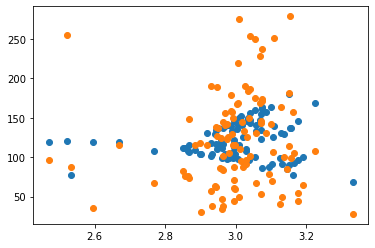

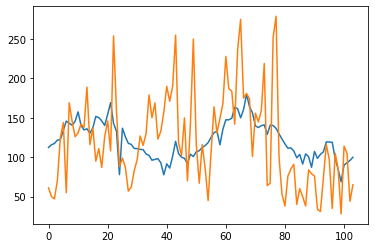

eta 7e-05
eta 4.899999999999999e-05
eta 7e-05
eta 4.899999999999999e-05
eta 7e-05
eta 4.899999999999999e-05
eta 7e-05
eta 4.899999999999999e-05
eta 7e-05
eta 4.899999999999999e-05
eta 7e-05
eta 4.899999999999999e-05
eta 7e-05
eta 4.899999999999999e-05
loss:  551.0642242063075
initialization:  0.5
w:  [ 4.7005203  -3.64224238  1.31608224 -3.64370313 -1.03954967  0.5       ]


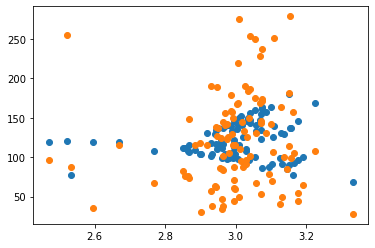

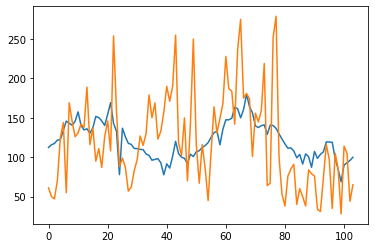

eta 7e-05
eta 4.899999999999999e-05
eta 7e-05
eta 4.899999999999999e-05
eta 7e-05
eta 4.899999999999999e-05
eta 7e-05
Product Suede And Nubuck Brush
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
loss:  557.8770080650477
initialization:  -3.0
w:  [ 4.82334268 -0.145649    0.06822131 -1.02863544  0.01812964 -3.        ]


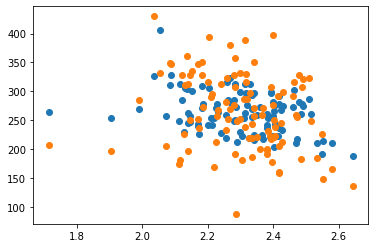

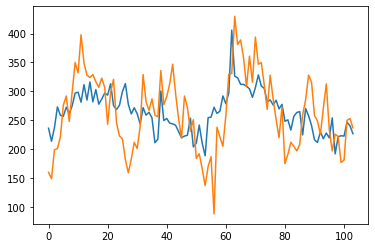

eta 7e-05
eta 4.899999999999999e-05
loss:  557.8770080648491
initialization:  -2.5
w:  [ 4.8233423  -0.14564908  0.06822134 -1.02863665  0.01812908 -2.5       ]


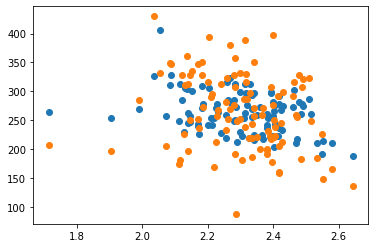

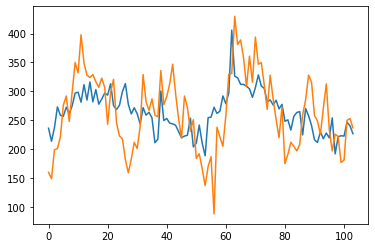

eta 7e-05
eta 4.899999999999999e-05
loss:  557.8770080647192
initialization:  -2.0
w:  [ 4.82334203 -0.14564914  0.06822137 -1.02863751  0.01812867 -2.        ]


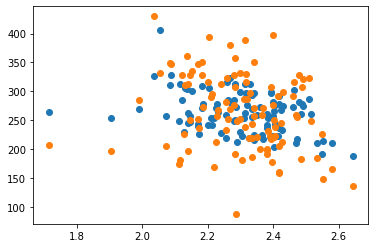

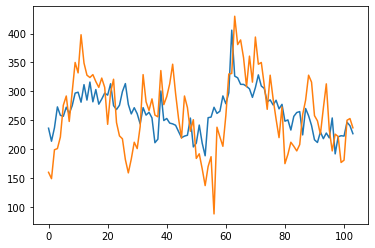

eta 7e-05
eta 4.899999999999999e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
Product Hotter Women's Insoles
Channel UK Direct
loss:  149.24865055903928
initialization:  -3.0
w:  [ 3.40886352  0.01538846 -0.04095444  0.01302302 -6.87092595 -3.        ]


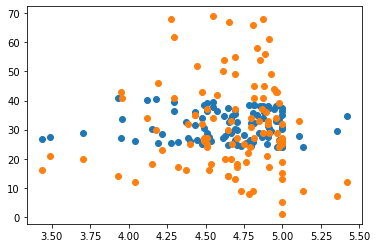

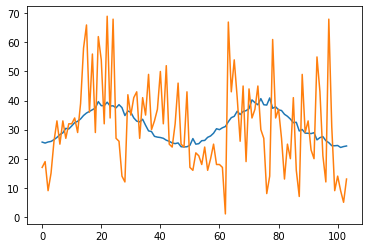

loss:  149.24850932383657
initialization:  -2.5
w:  [ 3.40885894  0.01536671 -0.04089594  0.01300665 -6.8785963  -2.5       ]


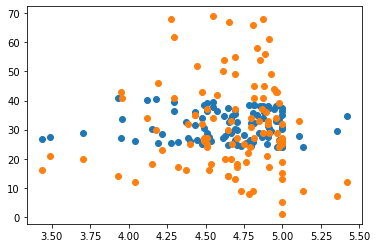

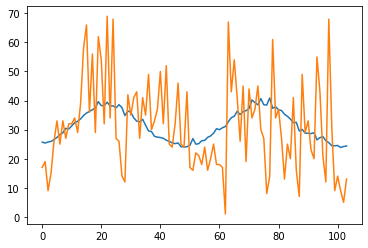

loss:  149.24840186060175
initialization:  -2.0
w:  [ 3.40885545  0.01535016 -0.04085143  0.01299419 -6.88444712 -2.        ]


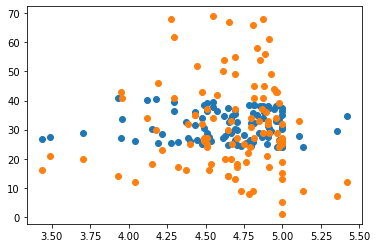

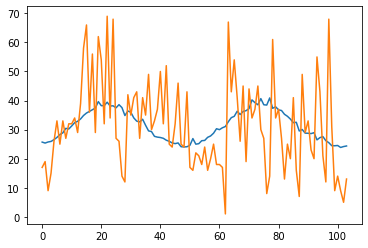

loss:  142.38066014218555
initialization:  -1.5
w:  [ 3.30214491 -0.50107975  1.33936625 -3.59588857 -1.37127471 -1.5       ]


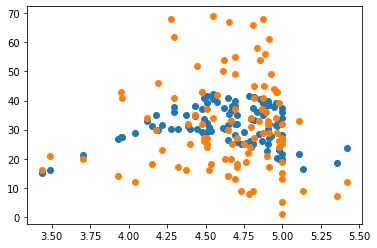

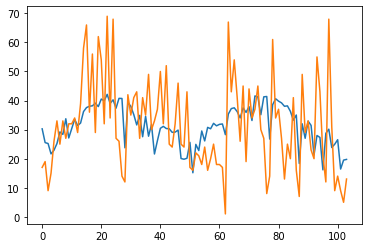

loss:  142.38066014215747
initialization:  -1.0
w:  [ 3.30214489 -0.50107979  1.33936632 -3.59588918 -1.37127472 -1.        ]


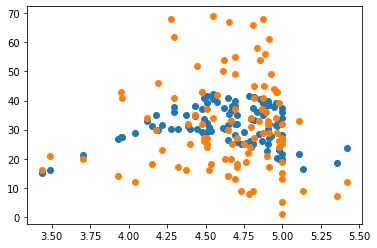

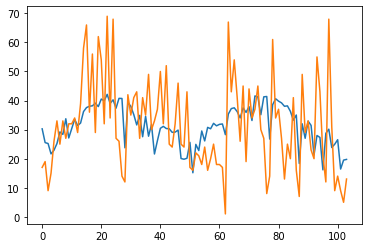

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


eta 7e-05
eta 7e-05
Product Hotter Women's Insoles
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
loss:  710.8640541152033
initialization:  -3.0
w:  [ 5.73983434 -2.05330791 -2.24880226  3.35500493 -1.63233481 -3.        ]


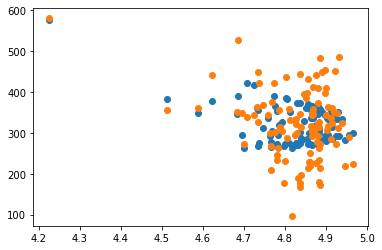

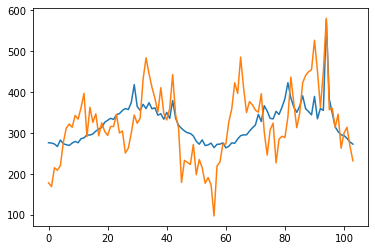

eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
loss:  710.8640541010599
initialization:  -2.5
w:  [ 5.73983411 -2.05328235 -2.24877531  3.35500344 -1.63233546 -2.5       ]


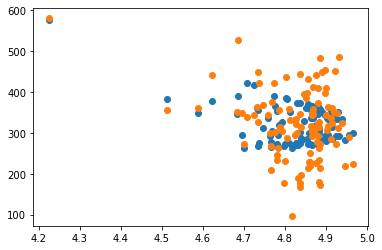

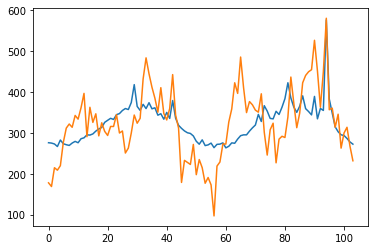

eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


eta 7e-05
eta 7e-05
Product Footwear Cleaner
Channel UK Direct
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-0

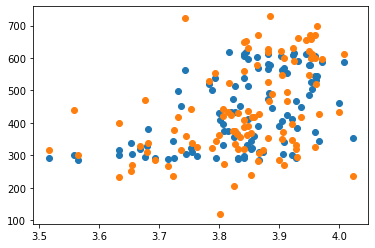

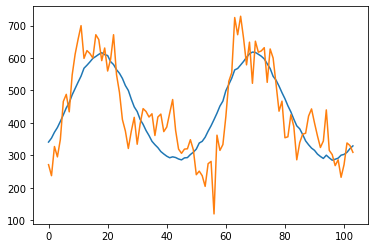

eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
loss:  849.7956347124145
initialization:  -2.5
w:  [ 6.01288793  0.05592001 -0.04507275  0.02841682 -6.69019318 -2.5       ]


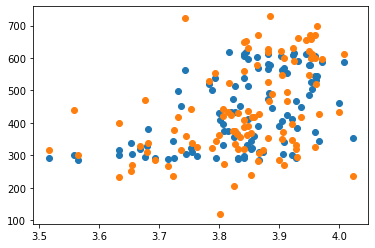

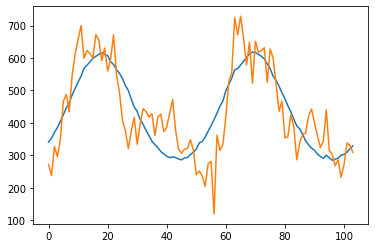

eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
loss:  849.79514320832
initialization:  -2.0
w:  [ 6.01288742  0.05590056 -0.04505706  0.0284072  -6.69205477 -2.        ]


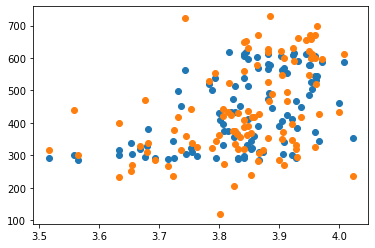

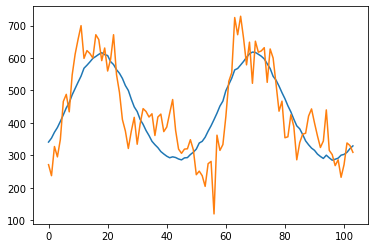

eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
loss:  849.783250132689
initialization:  -1.5
w:  [ 6.01287498  0.0554299  -0.04467736  0.02817415 -6.7375024  -1.5       ]


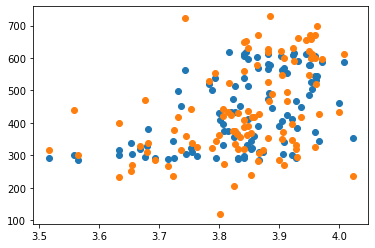

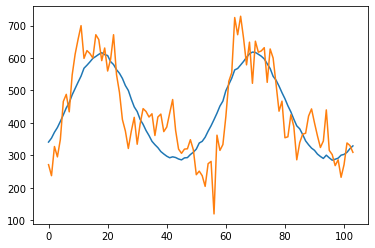

eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
loss:  807.0025457448929
initialization:  -1.0
w:  [ 5.87018807 -3.08611367  2.39922096 -8.2052072  -1.25275121 -1.        ]


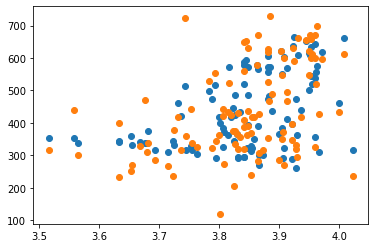

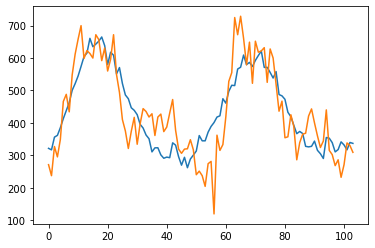

eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997

C:\Users\JAELFR~1\AppData\Local\Temp/ipykernel_17220/326464890.py:35: RuntimeWarning: invalid value encountered in double_scalars
  while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997

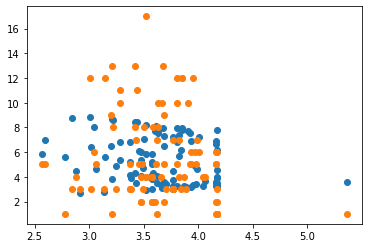

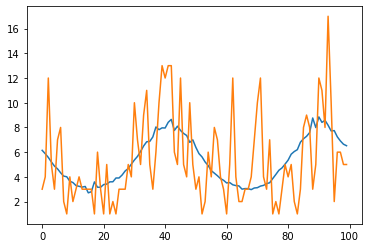

loss:  30.78465270787374
initialization:  -2.5
w:  [ 1.60626138 -0.35985858  0.23417112 -0.00660396 -2.46864817 -2.5       ]


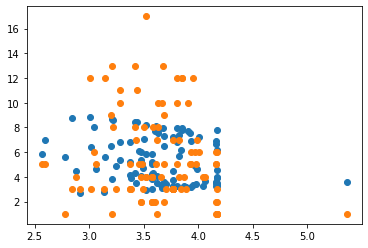

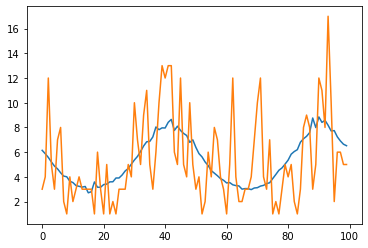

loss:  30.78464112970174
initialization:  -2.0
w:  [ 1.60614337 -0.35842334  0.23324945 -0.00635361 -2.47324989 -2.        ]


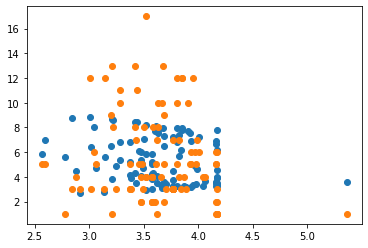

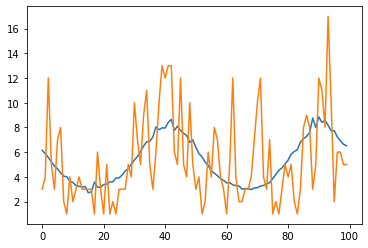

loss:  30.41479633308371
initialization:  -1.5
w:  [ 1.28039779  0.89564252 -0.7078779  -1.93034989 -0.88894495 -1.5       ]


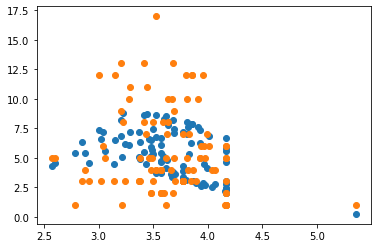

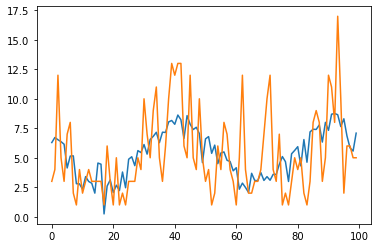

loss:  30.41479633305588
initialization:  -1.0
w:  [ 1.28042024  0.89561793 -0.70785149 -1.93015906 -0.8889323  -1.        ]


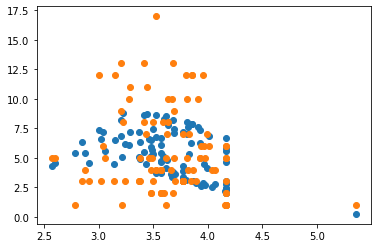

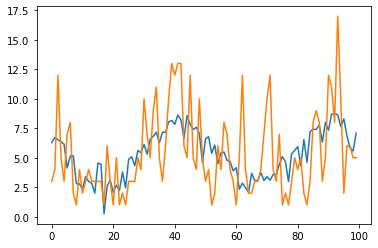

loss:  30.414796333039796
initialization:  0.5
w:  [ 1.28042014  0.89561803 -0.7078516  -1.93015986 -0.88893235  0.5       ]


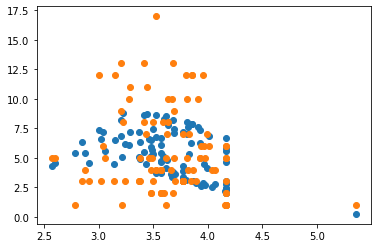

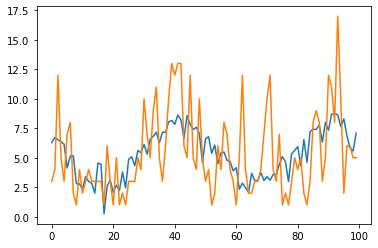

eta 7e-05
eta 7e-05
Product Wax Oil
Channel Retail - Full Price


C:\Users\JAELFR~1\AppData\Local\Temp/ipykernel_17220/326464890.py:35: RuntimeWarning: invalid value encountered in double_scalars
  while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


loss:  148.7559494665818
initialization:  -3.0
w:  [ 3.39685968 -2.68799735  0.99531566 -1.46609873 -1.52243832 -3.        ]


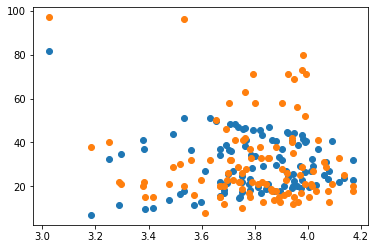

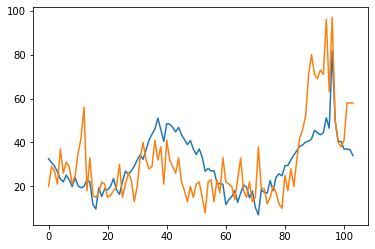

eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
Product Shake
Channel UK Direct
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
Product Shake
Channel Retail - Full Price
Product Rutland GTX
Channel UK Direct
Product Rutland GTX
Channel Retail - Full Price
eta 7e-05


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x
C:\Users\JAELFR~1\AppData\Local\Temp/ipykernel_17220/326464890.py:35: RuntimeWarning: invalid value encountered in double_scalars
  while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans

IndexError: index 13 is out of bounds for axis 0 with size 13

In [138]:
#ALL PRODUCTS
z=0
losses = np.zeros((13,14))
real = np.zeros((13,207))

used_model = model2
for prod in products:
    for channel in ['UK Direct','Retail - Full Price']:
        results = np.zeros((14,208))
        
        #We need to aggregate the results so we have a proper time series
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]#.groupby(['Date'], as_index=False).agg(aggregations) 
        data_prod = data_prod[['Price','Week_sin','Week_cos','Discount','sales']]


        print("Product",prod)
        print("Channel",channel)
        j=0
        loss_old = 1000
        for i in range(-6,6,1):
            X = data_prod.values[:,:-1]
            d = data_prod.values[:,-1]

            w = i/2*np.ones(6)
            w_o = i/2*np.ones(6)
            loss = 10e10
            loss_o = 10e11
            Niterations = 1000000
            eta=0.0001
            nit=0

            start_time = time.time()


            while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
                if loss>loss_o:
                    eta = eta*0.7
                    print('eta',eta) 
                w_o = w
                loss_o = loss

                gradients = my_training_gradient(d, X, w, model=used_model)
                w -= eta*gradients

                loss = my_autograd_loss(d,X,w,model=used_model)
                #print(nit, loss)

                #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                nit+=1

            losses[z,j] = my_autograd_loss(d,X,w,model=used_model)
            #results[j] = np.array(model5f(X,w))
            if loss< loss_old:
                print('loss: ',loss)
                print('initialization: ',i/2)
                print('w: ',w)
                
                plt.scatter(X[:,0],used_model(X,w))
                plt.scatter(X[:,0],d)
                plt.show()

                plt.plot(used_model(X,w))
                plt.plot(d)
                plt.show()
                
                loss_old=loss


            #print("nit",nit)
            j = j+1
        z = z+1






Product Suede And Nubuck Brush
Channel Retail - Full Price
Product Hotter Women's Insoles
Channel Retail - Full Price
Product Footwear Cleaner
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
loss:  1767.4624042570163
initialization:  -3.0
estimated parameters: [ 6.16193166  0.05890288 -0.05678969 -0.23498656 -5.4114076  -3.        ]


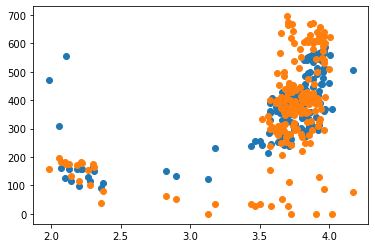

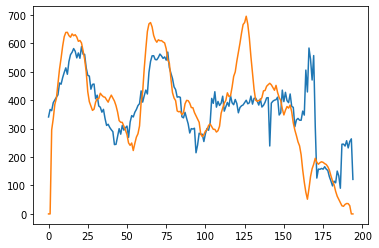

eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
loss:  1767.4623979200217
initialization:  -2.5
estimated parameters: [ 6.16193238  0.0588979  -0.05678492 -0.23496772 -5.41175617 -2.5       ]


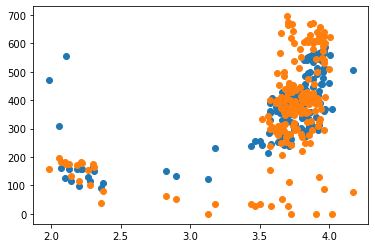

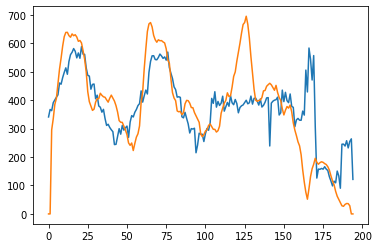

eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.2354299999

C:\Users\JAELFR~1\AppData\Local\Temp/ipykernel_17220/319908810.py:44: RuntimeWarning: invalid value encountered in double_scalars
  while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x


eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 2.8247524899999986e-06
eta 1.977326742999999e-06
eta 1.3841287200999992e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 2.8247524899999986e-06
eta 1.977326742999999e-06
eta 1.3841287200999992e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 2.8247524899999986e-06
eta 1.977326742999999e-06
eta 1.3841287200999992e-06
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Laurel
Channel Retail - Full Price
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 4.899999999999999e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
Product Leanne
Channel Retail - Full Price
Product Solar
Channel Retail - Full Price
Product Nova
Channel Retail - Full Price
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 4.899999999999999e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
Product Tone
Channel Retail - Full Price


In [128]:
#ALL PRODUCTS RESIDUAL
z=0
losses = np.zeros((13,14))
real = np.zeros((13,207))

used_model = model2
for prod in products:
    for channel in ['Retail - Full Price']:
        results = np.zeros((14,208))
        
        #We need to aggregate the results so we have a proper time series
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]#.groupby(['Date'], as_index=False).agg(aggregations) 
        series = data_prod[['Date','sales']].groupby(['Date']).sum()
        
        result = seasonal_decompose(series, model='additive', period=5)
        residual = pd.DataFrame(result.resid) + pd.DataFrame(result.trend)
        trend = pd.DataFrame(result.trend)
        trend = trend.rename(columns={'trend':'resid'})
        desc = residual.add(trend,fill_value=0)
        data_prod = data_prod.merge(desc, on='Date')        
        data_prod = data_prod[['Price','Week_sin','Week_cos','Discount','resid']]
        data_prod = data_prod.fillna(0)


        print("Product",prod)
        print("Channel",channel)
        j=0
        loss_old = 5000
        for i in range(-6,6,1):
            X = data_prod.values[:,:-1]
            d = data_prod.values[:,-1]

            w = i/2*np.ones(6)
            w_o = i/2*np.ones(6)
            loss = 10e10
            loss_o = 10e11
            Niterations = 1000000
            eta=0.0001
            nit=0

            start_time = time.time()


            while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
                if loss>loss_o:
                    eta = eta*0.7
                    print('eta',eta) 
                w_o = w
                loss_o = loss

                gradients = my_training_gradient(d, X, w, model=used_model)
                w -= eta*gradients

                loss = my_autograd_loss(d,X,w,model=used_model)
                #print(nit, loss)

                #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                nit+=1

            losses[z,j] = my_autograd_loss(d,X,w,model=used_model)
            #results[j] = np.array(model5f(X,w))
            if loss< loss_old:
                print('loss: ',loss)
                print('initialization: ',i/2)
                print('estimated parameters:',w)
                
                plt.scatter(X[:,0],used_model(X,w))
                plt.scatter(X[:,0],d)
                plt.show()

                plt.plot(used_model(X,w))
                plt.plot(d)
                plt.show()
                
                loss_old=loss


            #print("nit",nit)
            j = j+1
        z = z+1




